In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft,ifft,fftfreq,fftshift
import numba
from numba import njit, prange
from tqdm import tqdm

In [3]:
# Here I'm refactoring my two_state_process function into an optimized vectorized version that is also parallelizable

# The perturbation function that is called inside the generate_markov_jump_process function must be defined outside since numba can't handle nestef functions
@njit
def p(t,omega_p,epsilon):
    return epsilon * np.cos(omega_p*t)

@njit
def generate_markov_jump_process(number_of_substates: list, transition_rates: list, refractory_periods: list, total_time: float, delta_t: float, out = None, enable_perturbation = False, omega_p = 1.0, epsilon = 0.0):
    """Function creates a markov jump process that can be used to approximate
        a two state renewal process with refractory period.
        The outputs are two numpy arrays:
         - time_sequence containing a discrete time array up to total time with evenly spaced time steps delta t
         - state_sequence which contains the corresponding occupied state at each time step. The associated value is the state index from 0 to N+M and has to be mapped by a different function
        The other inputs are:
         - numpy array containing the number of substates N of chain A and the number of substates in M of chain B
         - numpy array of transition rates of the last state of each chain to the corresponding other chain
         - numpy array of refractory periods for the two chains that are aproximated by the N-1 / M-1 first substates of each chain
         - numpy array out which can be preallocated for efficiency in the use case of huge number of iterated calls of the function

        Noticably this function is optimized for parallel processing with Numba.
    """

    ### FLAGS ###
    transition_rates_substates_A_zero_flag = False
    transition_rates_substates_B_zero_flag = False
    no_states_in_chain_A_flag = False
    no_states_in_chain_B_flag = False
    #############


    N_A = number_of_substates[0]
    N_B = number_of_substates[1]
    
    target_sequence_length = int(np.floor(total_time/delta_t)) + 1
    sampling_rate = 1 / delta_t

    initial_state = 0
    current_state = initial_state

    # Define current time variable needed if we want to include a perturbation
    current_time = 0.0

    # Define position index in sequence
    pos = 0 

    # If no preallocated output array is provided create a new output array
    if out == None:
        out = np.empty(target_sequence_length)

    # Define transition rates of substates and handle divide by zero
    if refractory_periods[0] > 0.0:
        transition_rate_substates_A = (N_A - 1)/refractory_periods[0]    # in both cases for N substates we have N-1 transitions that approximate the refractory period
    else: 
        transition_rate_substates_A = 10**6
        print('Warning: The refactory period of chain A is zero!')
    if refractory_periods[1] > 0.0:  
        transition_rate_substates_B = (N_B-1)/refractory_periods[1]
    else: 
        transition_rate_substates_B = 10**6
        print('Warning: The refactory period of chain B is zero!')

    # Define static transition rate of last state of chain A and B
    transition_rate_A = transition_rates[0]
    transition_rate_B = transition_rates[1]

    # Now we fill the out array that holds the state sequence successively 
    while pos < target_sequence_length:
        # go through CHAIN A
        # first N_A-1 states approximate refractory period
        if N_A - 1 >= 0.0:
            if transition_rate_substates_A > 0.0:
                for substate_i in range(N_A - 1):
                    u = np.random.random()                  # This function generates uniformly distributed random numbers in [0,1). This method is used because rng.exponential is not supported in numba parallelization
                    while u == 0.0:                           # Avoid u = 0 since ln(0) = -infty
                        u = np.random.random()              # So we regenerate until u not equal to 0
                    residency_time = - np.log(u) / transition_rate_substates_A          # Transform uniformly sampled random variable into exponentially sampled time
                    # If we only floored the number of samples here we would introduce bias and make all residency times a little smaller
                    # Thus we probabilitsically ceil sometimes the rate of which is proportional to the difference between float and floored number of samples
                    frac = residency_time*sampling_rate - np.floor(residency_time*sampling_rate)
                    n_occupancy = max(1, int(np.floor(residency_time*sampling_rate) + (np.random.random() < frac)))        # We always at least spend one time step in each state even if n_occ would actually be less than 0
                    # Add vals to output array
                    end_pos = pos + n_occupancy
                    if end_pos > target_sequence_length:
                        end_pos = target_sequence_length
                    for k in range(pos,end_pos):
                        out[k] = current_state
                    # Update position index and state index
                    pos = end_pos
                    current_state += 1
                    current_time += n_occupancy * delta_t
                    # Break if state sequence is completely filled
                    if pos >= target_sequence_length:
                        break
            else:                                                           # Handle exceptions
                transition_rates_substates_A_zero_flag = True
                continue
        else: 
            no_states_in_chain_A_flag = True
            continue

        # Break if state sequence is completely filled after refractory substates
        if pos >= target_sequence_length:
            break

        # Handle last state of chain A seperatly
        if transition_rates[0] > 0.0:
            if enable_perturbation == False:
                u = np.random.random()
                while u == 0.0:                           
                    u = np.random.random()
                residency_time = - np.log(u) / transition_rate_A
            elif enable_perturbation == True:
                # Thinning algorithm
                accept = False
                tau = 0
                lambda_max = transition_rates[0]+epsilon
                while accept == False:
                    u = np.random.random()
                    while u == 0.0:                           
                        u = np.random.random()
                    # Sample first residency candidate
                    residency_time = - np.log(u) / lambda_max
                    tau += residency_time
                    current_transition_rate = transition_rates[0] + p(current_time + tau,omega_p,epsilon)
                    w = np.random.random()
                    if w <= current_transition_rate/(lambda_max):
                        accept = True
                        residency_time = tau
                    




            frac = residency_time*sampling_rate - np.floor(residency_time*sampling_rate)
            n_occupancy = max(1, int(np.floor(residency_time*sampling_rate) + (np.random.random() < frac))) 
            end_pos = pos + n_occupancy
            if end_pos > target_sequence_length:
                end_pos = target_sequence_length
            for k in range(pos,end_pos):
                out[k] = current_state
            # Update position index and state index
            pos = end_pos
            current_state += 1
            current_time += n_occupancy * delta_t
        else:           # If the transition rate is zero we stay in this state forever
            for k in range(pos,target_sequence_length):
                out[k] = current_state
            pos = target_sequence_length

        # Break if state sequence is completely filled
        if pos >= target_sequence_length:
            break

        ######

        # Move on to CHAIN B
        if N_B - 1 >= 0.0:
            if transition_rate_substates_B > 0.0:
                for substate_i in range(N_B - 1):
                    u = np.random.random()                  
                    while u == 0.0:                           
                        u = np.random.random()              
                    residency_time = - np.log(u) / transition_rate_substates_B         
                    frac = residency_time*sampling_rate - np.floor(residency_time*sampling_rate)
                    n_occupancy = max(1, int(np.floor(residency_time*sampling_rate) + (np.random.random() < frac)))     
                    # Add vals to output array
                    end_pos = pos + n_occupancy
                    if end_pos > target_sequence_length:
                        end_pos = target_sequence_length
                    for k in range(pos,end_pos):
                        out[k] = current_state
                    # Update position index and state index
                    pos = end_pos
                    current_state += 1
                    current_time += n_occupancy * delta_t
                    # Break if state sequence is completely filled
                    if pos >= target_sequence_length:
                        break
            else:                                                           # Handle exceptions
                transition_rates_substates_B_zero_flag = True
                continue
        else: 
            no_states_in_chain_B_flag = True
            continue

        # Break if state sequence is completely filled after refractory substates
        if pos >= target_sequence_length:
            break

        # Handle last state of chain B seperatly
        if transition_rates[1] > 0.0:
            u = np.random.random()
            while u == 0.0:                           
                u = np.random.random()
            residency_time = - np.log(u) / transition_rate_B
            frac = residency_time*sampling_rate - np.floor(residency_time*sampling_rate)
            n_occupancy = max(1, int(np.floor(residency_time*sampling_rate) + (np.random.random() < frac))) 
            end_pos = pos + n_occupancy
            if end_pos > target_sequence_length:
                end_pos = target_sequence_length
            for k in range(pos,end_pos):
                out[k] = current_state
            # Update position index and state index
            pos = end_pos
            current_state = 0  # Return to first state of chain A
            current_time += n_occupancy * delta_t
        else:           # If the transition rate is zero we stay in this state forever
            for k in range(pos,target_sequence_length):
                out[k] = current_state
            pos = target_sequence_length

        # Break if state sequence is completely filled
        if pos >= target_sequence_length:
            break

    # Flags
    if transition_rates_substates_A_zero_flag == True:
        print('Warning: The transition rates of the substates in chain A are zero. Are there no substates?')
    if no_states_in_chain_A_flag == True:
        print('Warning: There are no states in chain A!')
    if transition_rates_substates_B_zero_flag == True:
        print('Warning: The transition rates of the substates in chain B are zero. Are there no substates?')
    if no_states_in_chain_B_flag == True:
        print('Warning: There are no states in chain B!')

    # Generate time sequence
    time_sequence = np.arange(target_sequence_length) * delta_t
    # Clearify output
    state_sequence = out

    return time_sequence, state_sequence

@njit
def state_mapping(number_of_substates:list, state_sequence: np.array):
    N_A = number_of_substates[0]
    N_B = number_of_substates[1]

    seq = state_sequence.copy()

    mask_A = seq < N_A
    seq[mask_A] = -1 + seq[mask_A] / N_A
    seq[~mask_A] = (seq[~mask_A] - N_A + 1) / N_B
    
    return seq


In [4]:
# def function that hides the sequence of substates and identifies them with their "parent state" -1 or 1
def reduce_states(state_sequence):
    """
    Takes as input the array that contains the sequence of plotable states and identifies them with super states.

    """
    seq = state_sequence.copy()
    
    mask_A = seq < 0
    seq[mask_A] = -1
    seq[~mask_A] = 1

    return seq

def two_state_process_reduced(*args, **kwargs):
    time_sequence,state_sequence = generate_markov_jump_process(*args, **kwargs)
    number_of_substates = args[0]
    state_sequence = state_mapping(number_of_substates,state_sequence)
    state_sequence = reduce_states(state_sequence)
    return time_sequence,state_sequence

#the following function guarantees that the eigenvector that is chosen is a probability density, i.e. positive and normed to one
def norm_to_probability_density(x: np.array):
    if np.argmax(x) < 0:                   
        x = -x            
    x = 1/(np.sum(x)) * x
    return x

In [18]:
def build_generator_matrix(number_of_substates: list, transition_rates: list, refractory_periods: list):
    """
    Constructs the generator matrix (L) for the two-state renewal process
    with linear chains to model refractory periods.
    
    Args:
        number_of_substates (list): [N, M], the number of substates for state A and B.
        transition_rates (list): The final transition rates out of state A and B.
        refractory_periods (list): The desired mean refractory period for state A and B.

    Returns:
        array: The (N+M)x(N+M) generator matrix L.
    """
    #Define relevant parameters
    N = number_of_substates[0]
    M = number_of_substates[1]

    total_states = N + M

    transition_rates_substates_A = (N-1) / refractory_periods[0]
    transition_rates_substates_B = (M-1) / refractory_periods[1]

    transition_rate_final_A = transition_rates[0]
    transition_rate_final_B = transition_rates[1]

    #Initialize matrix
    L = np.zeros((total_states,total_states))

    for i in range(N-1):
        L[i,i] = (-1 * transition_rates_substates_A)
        L[i+1,i] = transition_rates_substates_A
    
    L[N-1,N-1] = (-1 * transition_rate_final_A)
    L[N,N-1] = transition_rate_final_A

    for i in range(N,N+M-1):
        L[i,i] = (-1 * transition_rates_substates_B)
        L[i+1,i] = transition_rates_substates_B

    L[N+M-1,N+M-1] = (-1 * transition_rate_final_B)
    L[0,N+M-1] = transition_rate_final_B

    return L


def calculate_and_order_eigenspectrum(L: np.array):
    """
    Calculates the eigenvalues of the generator matrix L.

    Args:  generator matrix L
    """
    #calculate lefthand eigenvalues
    eigenvalues_left_raw, eigenvectors_left = np.linalg.eig(L.T)     #since we want the lefthand eigenvectors, we take transpose the matrix here
    #Order eigenvalues by magnitude of real part. The resulting array starts with eigenvalues that have the most negative real part. 
    index_ordering = np.argsort(eigenvalues_left_raw.real)
    eigenvalues_left = eigenvalues_left_raw[index_ordering]
    #Since there are pairs of eigenvalues with same real part we have to make sure there is a unique ordering. Otherwise this is a source of error. We take the eigenvalues with positive imaginariy part first.
    for i in range(len(eigenvalues_left)-1):
        if eigenvalues_left[i].real == eigenvalues_left[i+1].real:
            if eigenvalues_left[i].imag > eigenvalues_left[i+1].imag:
                temp = index_ordering[i]
                index_ordering[i] = index_ordering[i+1]
                index_ordering[i+1] = temp
            else: continue
    eigenvalues_left = eigenvalues_left_raw[index_ordering]

    #Order eigenvectors according to the ordering of the eigenvalues
    ordered_eigenvectors_left = []
    for i in index_ordering:
        ordered_eigenvectors_left.append(eigenvectors_left[:,i])

    #Norm stationary left eigenvector to all ones
    for i in range(len(ordered_eigenvectors_left[-1])):
        ordered_eigenvectors_left[-1][i] = np.abs(1/(ordered_eigenvectors_left[-1][i]) * ordered_eigenvectors_left[-1][i])
    

    ################################################

    #calculate righthand eigenvalues
    eigenvalues_right_raw, eigenvectors_right = np.linalg.eig(L)
    
    idx_order = np.argsort(eigenvalues_right_raw.real)
    eigenvalues_right = eigenvalues_right_raw[idx_order]
    #Since there are pairs of eigenvalues with same real part we have to make sure there is a unique ordering. Otherwise this is a source of error. We take the eigenvalues with positive imaginariy part first.
    for i in range(len(eigenvalues_right)-1):
        if eigenvalues_right[i].real == eigenvalues_right[i+1].real:
            if eigenvalues_right[i].imag > eigenvalues_right[i+1].imag:
                temp = idx_order[i]
                idx_order[i] = idx_order[i+1]
                idx_order[i+1] = temp
            else: continue
    eigenvalues_right = eigenvalues_right_raw[idx_order]

    #Order eigenvectors according to the ordering of the eigenvalues
    ordered_eigenvectors_right = []
    for i in idx_order:
        ordered_eigenvectors_right.append(eigenvectors_right[:,i])

    #Norm stationary right eigenvector so that it is a probability distribution
    ordered_eigenvectors_right[-1] = norm_to_probability_density(ordered_eigenvectors_right[-1])

    #Norm the left eigenvectors Q_i to unit variance, as detailed in the paper eq. 9
    for i in range(len(ordered_eigenvectors_left)-1):
        variance = 0
        for j in range(len(ordered_eigenvectors_left[i])):
            variance += np.abs(ordered_eigenvectors_left[i][j])**2 * ordered_eigenvectors_right[-1][j]
        ordered_eigenvectors_left[i] = (1/np.sqrt(variance)) * ordered_eigenvectors_left[i]

    #Enforce biorthogonality 
    for i in range(len(ordered_eigenvectors_right)-1):
        dot_product = ordered_eigenvectors_right[i]@ordered_eigenvectors_left[i]
        ordered_eigenvectors_right[i] = (1/dot_product) * ordered_eigenvectors_right[i]

    return eigenvalues_left,ordered_eigenvectors_left,ordered_eigenvectors_right

def analyzing_and_plotting_eigenspectrum(ordered_eigenvalues, ordered_eigenvectors_left, ordered_eigenvectors_right):
    stationary_eigenvalue = ordered_eigenvalues[-1]

    #the eigenvalue of interest is the eigenvalue with the the largest non-zero real part
    lambda_1 = ordered_eigenvalues[-2]
    mu_1 = lambda_1.real
    omega_1 = lambda_1.imag

    #stationary left eigenvector
    Q_0 = ordered_eigenvectors_left[-1]
    #the following line guarantee that the eigenvalue that is chosen is a probability density, i.e. positive and normed to one

    #the left eigenvector Q_1 that corresponds to the lambda_1
    Q_1 = ordered_eigenvectors_left[-2]
    #Q_1 = norm_to_probability_density(Q_1)
    
    sum_entries_Q_0 = np.sum(Q_0)
    sum_entries_Q_1 = np.sum(Q_1)

    #stationary right eigenvector
    P_0 = ordered_eigenvectors_right[-1]
    #P_0 = norm_to_probability_density(P_0)

    #the right eigenvector P_1 that corresponds to the lambda_1
    P_1 = ordered_eigenvectors_right[-2]
    #P_1 = norm_to_probability_density(Q_1)
    
    sum_entries_P_0 = np.sum(P_0)
    sum_entries_P_1 = np.sum(P_1)


    print("-" * 30)
    print(f"Number of eigenvalues: {len(ordered_eigenvalues)}")
    print(f"Stationary Eigenvalue: {stationary_eigenvalue:.4f}")
    print(f"Oscillatory Eigenvalue (λ₁): {lambda_1:.4f}")
    print(f"Quality factor: {np.abs(omega_1/mu_1)}")
    print("-" * 30)
    print(f"Stationary lefthand Eigenvector: {Q_0}")
    print(" " * 30)
    print(f"Sum of elements of stationary lefthand eigenvector: {sum_entries_Q_0}")
    print(" " * 30)
    print(f"Oscillatory Eigenvector (Q₁): {Q_1}")
    print(" " * 30)
    print(f"Sum of elements of Q₁: {sum_entries_Q_1}")
    print("-" * 30)
    print(f"Stationary righthand Eigenvector: {P_0}")
    print(" " * 30)
    print(f"Sum of elements of stationary righthand eigenvector: {sum_entries_P_0}")
    print(" " * 30)
    print(f"Oscillatory Eigenvector (P₁): {P_1}")
    print(" " * 30)
    print(f"Sum of elements of P₁: {sum_entries_P_1}")


    #Plotting

    # Plotting
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot all eigenvalues
    ax.scatter(ordered_eigenvalues.real, ordered_eigenvalues.imag, c='teal', alpha=0.6, label='Other Eigenvalues')
    ax.scatter(ordered_eigenvalues.real, -ordered_eigenvalues.imag, c='teal', alpha=0.6) # Plot conjugates

    #Highlight eigenvalue with largest non-zero real part
    ax.scatter(lambda_1.real, lambda_1.imag, c='red', alpha=1, s=150, label=f'$\lambda_1$ = {mu_1:.2f} + {omega_1:.2f}i')
    ax.scatter(lambda_1.real, -lambda_1.imag, c='red', alpha=1, s=150) # Plot conjugates

    # Annotate the plot
    ax.axhline(0, color='black', lw=0.5)
    ax.axvline(0, color='black', lw=0.5)
    ax.set_xlim(np.min(ordered_eigenvalues.real) - 0.5, 0 + 0.5)
    ax.set_xlabel("Re(λ)", fontsize=14)
    ax.set_ylabel("Im(λ)", fontsize=14)
    ax.set_title("Eigenvalue Spectrum of the Generator Matrix", fontsize=16, weight='bold')
    ax.legend(fontsize=12)
    ax.grid(True)

    plt.show()


In [45]:
#calculate the conditional transition probability from the obtained eigenvetors
def transition_probability(eigenvalues: list, left_eigenvectors: list, right_eigenvectors: list ,initial_state: int,target_state: int,time: float):
        spectral_sum = 0
        for i in range(len(left_eigenvectors)-1):
            spectral_sum += np.exp(eigenvalues[i] * time) * right_eigenvectors[i][target_state] * left_eigenvectors[i][initial_state]
        return right_eigenvectors[-1][target_state] + spectral_sum

In [7]:
#define function that calculates power spectrum for given sequence of time and states by averaging over many realizations of the process
def power_spectrum(process_generator, realizations: int, *args, **kwargs):
    #process generator must return two arrays, one time sequence and one state sequence
    #call process generator once to initialize variables:
    time_sequence,state_sequence = process_generator(*args,**kwargs)
    if process_generator is generate_markov_jump_process:
        number_of_substates = args[0]                                           #### It is important now that number of substates is passed as first argument
        state_sequence = state_mapping(number_of_substates, state_sequence=state_sequence)
    #state_sequence = reduce_states(state_sequence)                              ####   if this line is uncommented the power spectrum of the superstates is calculated 
    number_sample_points = len(time_sequence)
    dt = time_sequence[1]-time_sequence[0]
    average = np.zeros(number_sample_points)
    #calculate first iteration with initialized variables
    ft_state_sequence = fft(state_sequence)*dt
    average += np.abs(ft_state_sequence)**2

    #calculate ensemble average over remaining realizations
    for i in range(1,realizations):
        time_sequence,state_sequence = process_generator(*args,**kwargs)
        if process_generator is generate_markov_jump_process:
            number_of_substates = args[0]  
            state_sequence = state_mapping(number_of_substates, state_sequence=state_sequence)
        #state_sequence = reduce_states(state_sequence)                          ####   if this line is uncommented the power spectrum of the superstates is calculated
        ft_state_sequence = fft(state_sequence)*dt
        if len(average) == len(ft_state_sequence):
            average += np.abs(ft_state_sequence)**2
        else: 
            print(f'Flag for realisation {i}')
            print(f'Mismatch: {len(average)} is not equal to {len(ft_state_sequence)}')

    #calculate final outputs
    frequency_sequence = fftfreq(number_sample_points,dt)
    power_spectrum_sequence = average/(realizations * (len(time_sequence)*dt))

    return frequency_sequence,power_spectrum_sequence

In [78]:
@njit
def phase_reduction(state_sequence: np.array, Q_1: np.array):
    
    Q_1_sequence = np.zeros(len(state_sequence), dtype=np.complex128)

    # tracks which values are assumed by the state sequence
    state_vals = np.unique(state_sequence)
    
    #create dictionary with all state vals and associate index with them
    state_index_dict = {
        value: index for index, value in enumerate(state_vals)
    }

    for i in range(len(state_sequence)):
        #reconstruct the state index from the trajectory value
        ### this assumes that the initial state is -1 and the indexing increases monotonically until state 1 is reached, i.e. -1 has index 0 and 1 has index 19
        x = state_sequence[i]
        state_index = state_index_dict[x]

        #assign calculated Q_1 value
        Q_1_sequence[i] = Q_1[state_index]
        
    complex_argument_Q_1 = np.angle(Q_1_sequence)

    return Q_1_sequence

def phase_reduced_process(time_sequence: list, state_sequence:list, Q_1: np.array):

    complex_argument_Q_1 = phase_reduction(state_sequence, Q_1)

    return time_sequence, complex_argument_Q_1


In [76]:
#the theoretically expected power spectrum of Q_1
def power_spectrum_theoretical_Q_1(eigenvalue: np.complex128, omega: float):
    mu_1 = eigenvalue.real
    omega_1 = eigenvalue.imag
    return (2*np.abs(mu_1)) / (mu_1**2 + (omega - omega_1)**2)

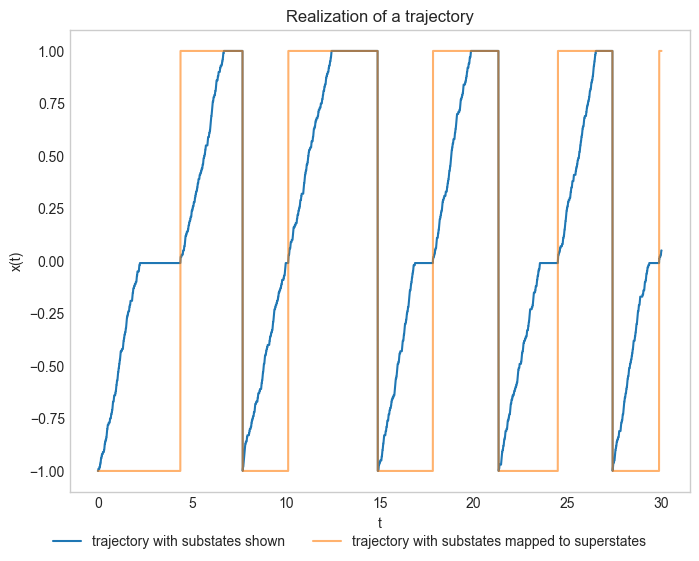

------------------------------
Number of eigenvalues: 200
Stationary Eigenvalue: 0.0000+0.0000j
Oscillatory Eigenvalue (λ₁): -0.1728+1.1034j
Quality factor: 6.386321208391994
------------------------------
Stationary lefthand Eigenvector: [1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1

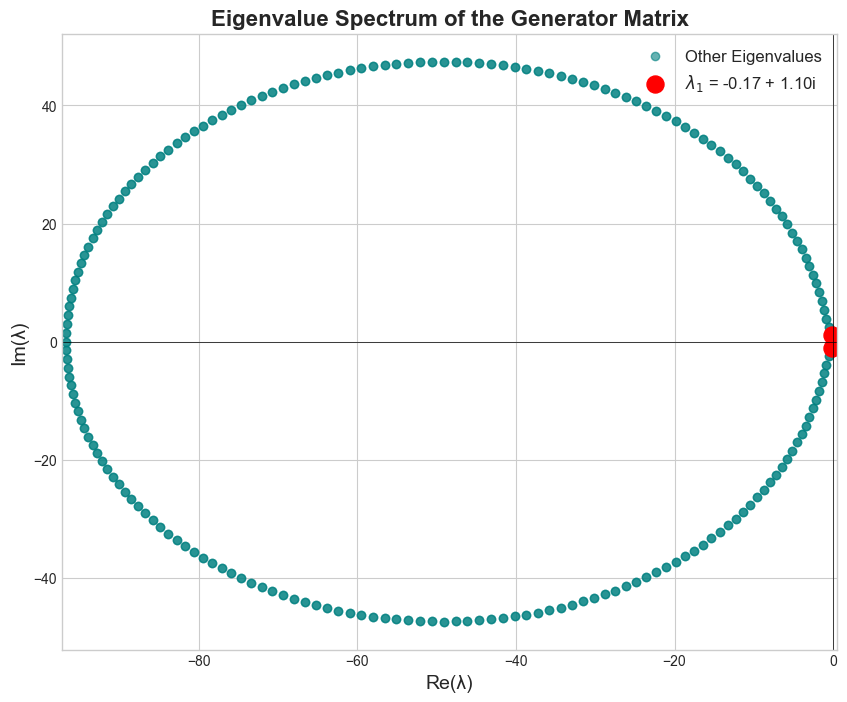

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


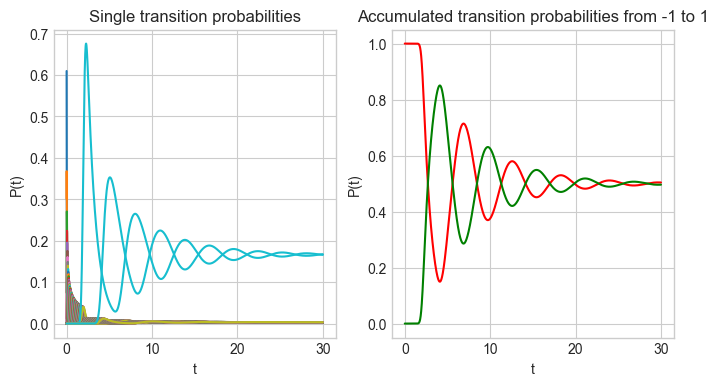

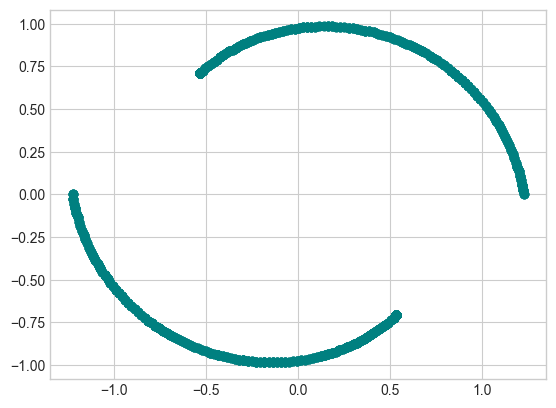

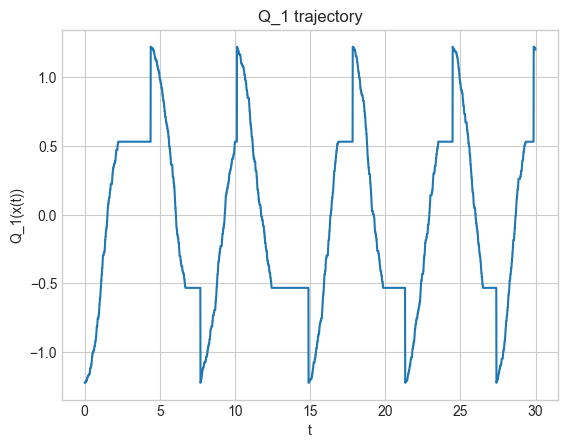

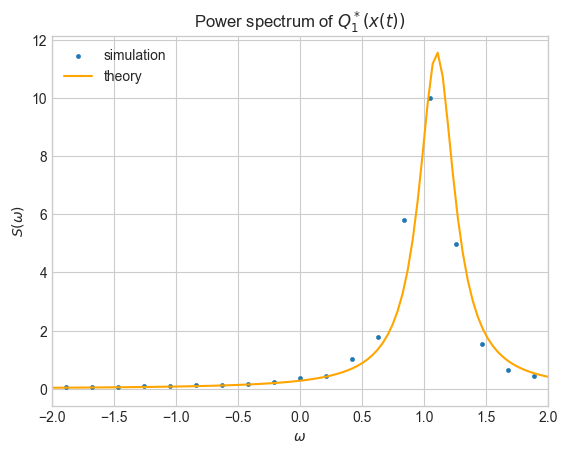

In [84]:
# Parameters
N = 100
M = 100
number_of_substates = [N,M]
transition_rates = [1,1]
refractory_periods = [2,2]
total_time = 30
delta_t = 0.01

#Plot a trajectory for the given parameters
# Create a figure
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
generated_time_sequence, generated_state_trajectory = generate_markov_jump_process(number_of_substates, transition_rates, refractory_periods, total_time, delta_t)
generated_state_trajectory = state_mapping(number_of_substates, generated_state_trajectory)
ax1.set_title('Realization of a trajectory')
ax1.plot(generated_time_sequence, generated_state_trajectory, label='trajectory with substates shown')


#Plot reduced trajectory for the given parameters
reduced_state_trajectory = reduce_states(generated_state_trajectory)
ax1.plot(generated_time_sequence, reduced_state_trajectory, label='trajectory with substates mapped to superstates', alpha = 0.6)
ax1.set_xlabel('t')
ax1.set_ylabel('x(t)')
ax1.grid(False)
fig.legend(loc='lower center', ncols = 2)
plt.show()


#Build generator matrix
L = build_generator_matrix(number_of_substates,transition_rates,refractory_periods)

#Calculate eigenspectrum
eigenvals,Q,P = calculate_and_order_eigenspectrum(L)
#Analyze and plot eigenspectrum
analyzing_and_plotting_eigenspectrum(eigenvals,Q,P)

#Plot transition probability over time for a specific pair of states
fig2, (ax1,ax2) = plt.subplots(1,2,figsize = (8,4))
ax1.set_title('Single transition probabilities')
ax1.set_xlabel('t')
ax1.set_ylabel('P(t)')
for i in range(N+M):
    generated_transition_probability = [transition_probability(eigenvals,Q,P,0,i,time+0.01) for time in generated_time_sequence]
    ax1.plot(generated_time_sequence,generated_transition_probability)

ax2.set_title('Accumulated transition probabilities from -1 to 1')
ax2.set_xlabel('t')
ax2.set_ylabel('P(t)')

accum_transition_probability_A = [0 for time in generated_time_sequence]
accum_transition_probability_B = [0 for time in generated_time_sequence]
for i in range(N):
    accum_transition_probability_A = np.add(accum_transition_probability_A,[transition_probability(eigenvals,Q,P,0,i,time+0.01) for time in generated_time_sequence])
for i in range(M):
    accum_transition_probability_B = np.add(accum_transition_probability_B,[transition_probability(eigenvals,Q,P,0,N+i,time+0.01) for time in generated_time_sequence])
ax2.plot(generated_time_sequence,accum_transition_probability_A,color='red')
ax2.plot(generated_time_sequence,accum_transition_probability_B,color='green')
plt.show()

#Perform transformation to Q_1:
Q_1_sequence = phase_reduction(generated_state_trajectory,Q[-2])
plt.scatter(Q_1_sequence.real, Q_1_sequence.imag, c='teal', alpha=0.6)
plt.show()
#complex_argument = np.angle(Q_1_sequence)
plt.plot(generated_time_sequence,Q_1_sequence)
plt.title('Q_1 trajectory')
plt.xlabel('t')
plt.ylabel('Q_1(x(t))')
plt.show()

#Plot power spectrum Q_1(t):
f,S = power_spectrum(phase_reduced_process, 1, generated_time_sequence, generated_state_trajectory, Q[-2])
accum = np.zeros(len(S)) 
for i in range(100):
    generated_time_sequence, generated_state_trajectory = generate_markov_jump_process(number_of_substates, transition_rates, refractory_periods, total_time, delta_t)
    generated_state_trajectory = state_mapping(number_of_substates, generated_state_trajectory)
    S = power_spectrum(phase_reduced_process, 1, generated_time_sequence, generated_state_trajectory, Q[-2])[1]
    accum += S
accum = 1/100 * accum
l = len(f)
f_shifted = fftshift(f)
#the theoretical formula is given for an angular frequency omega, so we have to convert the frequency into the angular frequency
omega = 2*np.pi * f_shifted
omega_plot = np.linspace(-2,2,100)
accum_shifted = fftshift(accum)
plt.scatter(omega,accum_shifted,linewidths=0.4, marker='.', label='simulation')
plt.plot(omega_plot,[power_spectrum_theoretical_Q_1(eigenvals[-2],x) for x in omega_plot],color='orange', label='theory')
plt.xlim(-2,2)
plt.title('Power spectrum of $Q_1^*(x(t))$')
plt.xlabel('$\omega$')
plt.ylabel('$S(\omega)$')
plt.legend()
plt.show()


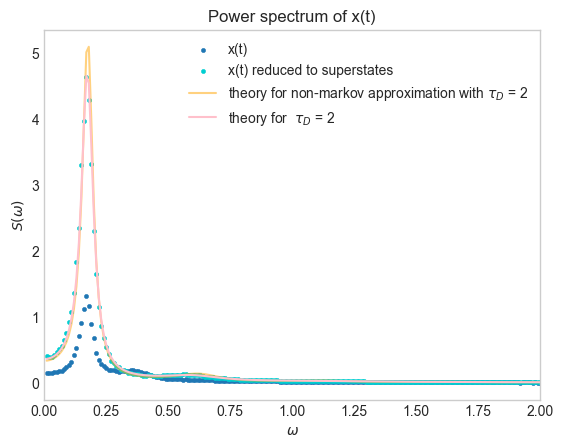

In [35]:
### Testing the power spectrum function for the trajectory and compare it with the non markovian version of the two state porcess
### Qualitatively the function works in this case but the scaling is of. On the point distribution it worked though. So the question remains if the function is off for some unknown reason
### or if our markovian process behaves differently

### ANSWER: The different value assignment of the substates changes the value of the power spectrum. If the substates are identified with its superstate, then the power spectra are the same

# Parameters
N = 50
M = 50
number_of_substates = [N,M]
transition_rates = [1,1]
refractory_periods = [2,2]
total_time = 100
delta_t = 0.01
sim_params = [number_of_substates,number_of_substates,refractory_periods,total_time,delta_t]

# define theoretical power spectrum for non-markovian process that is approximated
def S_approx(f,tau_D):
    return 0.5 * (((1+1)**2 * 1**2)/(1+tau_D)) / (1 + np.cos(2*np.pi*f*tau_D) - 2*np.pi*f*1*np.sin(2*np.pi*f*tau_D) + 2*(np.pi*f*1)**2)

# define theoretical power spectrum for markovian process that we actually have
def S(f: float, refractory_periods:list, final_transition_rates:list, number_of_substates:list):
    N = number_of_substates[0]
    M = number_of_substates[1]
    lambda_A = (N-1)/refractory_periods[0]
    lambda_B = (M-1)/refractory_periods[1]
    lambda_N = final_transition_rates[0]
    lambda_M = final_transition_rates[1]
    FT_rho_A = (lambda_A / (2j*np.pi*f + lambda_A))**(N-1) * (lambda_N/(2j*np.pi*f + lambda_N))
    FT_rho_B = (lambda_B / (2j*np.pi*f + lambda_B))**(M-1) * (lambda_M/(2j*np.pi*f + lambda_M))

    val_super_A = 1
    val_super_B = -1
    mean_residency_time_A = refractory_periods[0] + 1/lambda_N
    mean_residency_time_B = refractory_periods[1] + 1/lambda_M

    S = (2*(val_super_A - val_super_B)**2)/((mean_residency_time_A + mean_residency_time_B)*(2*np.pi*f)**2)  * ((1-FT_rho_A)*(1-FT_rho_B)/(1-FT_rho_A*FT_rho_B)).real
    
    return S

f,psd = power_spectrum(generate_markov_jump_process,1000,number_of_substates,transition_rates,refractory_periods,total_time,delta_t)
f2,psd2 = power_spectrum(two_state_process_reduced,1000, number_of_substates,transition_rates,refractory_periods,total_time,delta_t)
N = len(f)
plt.xlim(0,2)
plt.scatter(f[1:N//2],psd[1:N//2],linewidths=0.4, marker='.', label='x(t)')
plt.scatter(f2[1:N//2],psd2[1:N//2],linewidths=0.4, marker='.', color = 'darkturquoise', label = 'x(t) reduced to superstates')
plt.plot(f[1:N//2],[S_approx(x,2) for x in f[1:N//2]], label=f'theory for non-markov approximation with $\\tau_D$ = {2}', color = 'orange', alpha = 0.5)
plt.plot(f2[1:N//2],[S(x,refractory_periods, transition_rates, number_of_substates) for x in f[1:N//2]], label=f'theory for  $\\tau_D$ = {2}', color = 'pink')
plt.title('Power spectrum of x(t)')
plt.xlabel('$\omega$')
plt.ylabel('$S(\omega)$')
plt.legend()
plt.grid(False)
plt.show()

In [37]:
# Recasting the relevant eigenvector as numpy array since numba can't handle python objects like lists
Q_1 = np.array(Q[-2])

# Main parallel function
@njit(parallel=True)
def fill_batch_in_parallel(number_of_substates, transition_rates, refractory_periods, total_time, delta_t, out, enable_phase_reduction = False, omega_p = 1.0, epsilon = 0.0):
    sequence_length = out.shape[1]    
    for j in prange(out.shape[0]):      # runs parallel across trajectories
        temp_float_array = np.empty(sequence_length, dtype=np.float64)
        state_sequence_float = generate_markov_jump_process(number_of_substates, transition_rates, refractory_periods, total_time, delta_t, temp_float_array, enable_perturbation=True, omega_p=omega_p, epsilon = epsilon)[1]
        state_sequence_float = state_mapping(number_of_substates, state_sequence_float)

        # Cast state-sequence as complex to always handle type inference correctly
        state_sequence = state_sequence_float.astype(np.complex128)
        # If enable_phase_reduction is enabled we perform the mapping to Q_1
        if enable_phase_reduction == True:
            state_sequence = phase_reduction(state_sequence_float, Q_1)

        for k in range(sequence_length):                   
                out[j,k] = state_sequence[k]

    return out



def get_mean_and_variance(N_realizations, batch_size, number_of_threads, number_of_substates, transition_rates, refractory_periods, total_time, delta_t, enable_phase_reduction = False, omega_p = 1.0, epsilon = 0.0):
    
    # Set number of threads
    if number_of_threads is not None:
        numba.set_num_threads(number_of_threads)
    
    sequence_length = int(np.floor(total_time/delta_t)) + 1
    number_of_batches = int(np.ceil(N_realizations/batch_size))

    ## Initialize accumulators
    mean = np.empty(sequence_length, dtype=np.complex128)
    # This is the mean squared difference
    M2 = np.empty(sequence_length, dtype=np.complex128)

    counter = 0

    # Define action on each batch
    for i in range(number_of_batches):
        # Check if for last batch the batch size has to be modified
        id_of_first_element_in_batch = i * batch_size
        remaining_elements = N_realizations - id_of_first_element_in_batch
        this_batch_size = batch_size if remaining_elements >= batch_size else remaining_elements

        # Preallocate array that holds this_batch_size many trajectories
        out = np.empty((this_batch_size,sequence_length), dtype=np.complex128)

        # Compute batch in parallel
        out = fill_batch_in_parallel(number_of_substates, transition_rates, refractory_periods, total_time, delta_t, out, enable_phase_reduction, omega_p, epsilon)


        batch_mean = np.mean(out, axis=0)
        diff = np.abs(out - batch_mean[np.newaxis, :])
        batch_M2 = (diff * diff).sum(axis=0)

        # Accumulate
        m = this_batch_size
        n = counter

        if n == 0:
            mean[:] = batch_mean
            M2[:] = batch_M2
            counter = m
        else:
            delta = batch_mean - mean
            new_mean = (n*mean + m*batch_mean)/(n+m)
            new_M2 = M2 + batch_M2 + (delta * delta) * (n * m / (n + m))
            mean[:] = new_mean
            M2[:] = new_M2
            counter += m

        # optional progress
        #if (i + 1) % 10 == 0 or (i == number_of_batches - 1):
            #print(f"Processed batch {i+1}/{number_of_batches}, total realizations: {counter}")

    var = M2/(counter - 1)

    return mean, var


  0%|          | 0/1 [00:00<?, ?it/s]

The considered time window is 59.849999999999994 to 198.07999999999998, i.e. a total duration of 138.23.
Thus the sampling spacing in frequency space should be 0.00723431961224047.


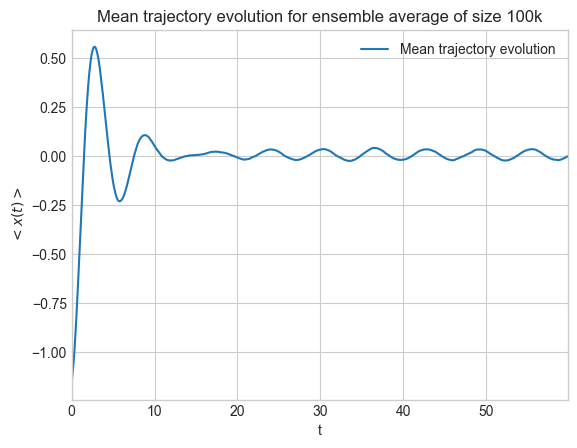

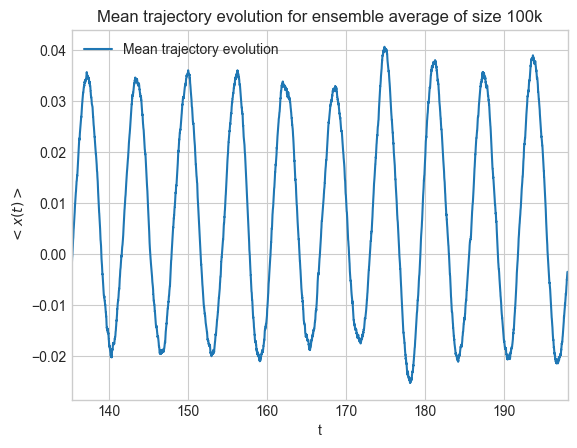

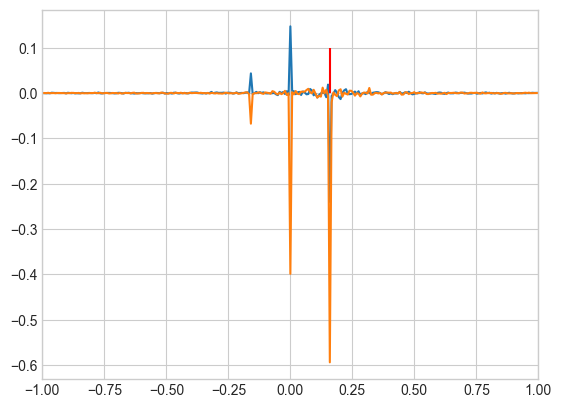

100%|██████████| 1/1 [00:22<00:00, 22.31s/it]

The frequency samples at f_p and f_p + delta f are :0.15915503146929033, 0.1663893510815308. Thus the actual spacing is 0.00723431961224047.
The actual perturbation frequency f_p hoever is: 0.15915494309189535.
(0.007428663216002529-0.019917326448152937j)


In [ ]:
N = 10
M = 10
number_of_substates = [N,M]
transition_rates = [1,1]
refractory_periods = [2,2]
total_time = 200
delta_t = 0.01

# Control if data is shown or not
plot_flag = True

#perturbation frequency
omega_p_list = [1]
epsilon_list = [0.1]

n_realizations = 100000
batch_size = 1000                
numba_threads = 8  

chi_estimators_list = []
chi_estimator_abs_square_list = []
chi_estimator_phase_list = []

for omega_p in tqdm(omega_p_list):
    # mean trajectory calculation
    plot_index = -2000
    traj_mean, traj_var = get_mean_and_variance(n_realizations, batch_size, numba_threads, number_of_substates, transition_rates, refractory_periods, total_time,delta_t, enable_phase_reduction=True, omega_p = omega_p, epsilon = epsilon_list[0])
    t = np.linspace(0,total_time,int(total_time/delta_t)+1)
    offset = -0.007157845668747328+0.019584590971231188j   #for some reason there is a systemic offset whixch needs to be corrected
    traj_mean = traj_mean - offset


    # windowing
    period_length = 2*np.pi / np.abs(omega_p) if omega_p!= 0 else np.round(2*np.pi, int(-np.log10(delta_t)))
    window_length = np.round(1000 * period_length, int(-np.log10(delta_t)))

    transient_time = np.round(10*(2*np.pi/(eigenvals[-2].imag)), int(-np.log10(delta_t)))  # let system settle
    transient_time_id = int(transient_time/delta_t)

    period_start_index = np.argmax(np.isclose(traj_mean[transient_time_id:].real,np.zeros(len(t[transient_time_id:])),atol=0.0005))
    t_start = transient_time + t[period_start_index]
    t_start_id = int(t_start/delta_t)
    t_end = t_start + window_length if t_start + window_length <= total_time else t_start + np.round(np.floor((total_time-t_start)/period_length) * period_length, int(-np.log10(delta_t)))
    t_end_id = int(t_end/delta_t)

    window_length = t_end - t_start

    if plot_flag:
        print(f'The considered time window is {t_start} to {t_end}, i.e. a total duration of {window_length}.')
        print(f'Thus the sampling spacing in frequency space should be {1/window_length}.')

        plt.plot(t[t_start:t_end_id],traj_mean[t_start:t_end_id], label='Mean trajectory evolution')
        plt.title(f'Mean trajectory evolution for ensemble average of size {int(n_realizations/1000)}k')
        plt.xlabel('t')
        plt.ylabel('$<x(t)>$')
        plt.xlim(t_start,t_start + 10*period_length)
        plt.legend()
        plt.show()

        plt.plot(t[t_start_id:t_end_id],traj_mean[t_start_id:t_end_id], label='Mean trajectory evolution')
        plt.title(f'Mean trajectory evolution for ensemble average of size {int(n_realizations/1000)}k')
        plt.xlabel('t')
        plt.ylabel('$<x(t)>$')
        plt.xlim(t_end - 10*period_length, t_end)
        plt.legend()
        plt.show()

    # fourier transform of mean trajectory
    freqs = fftshift(fftfreq(len(traj_mean[t_start_id:t_end_id]),delta_t))
    spectrum = fftshift(fft(traj_mean[t_start_id:t_end_id])) * delta_t

    # Modified spectrum to fit estimator for chi
    if omega_p != 0:
        spectrum = 2/(0.1*window_length) * spectrum
    else: 
        spectrum = 1/(0.1*window_length) * spectrum   # we have a different scaling factor for omega=0!!

    # output spectrum value of perturbation frequency
    f_p = omega_p/(2*np.pi)
    f_p_index = np.argmin(np.abs(f_p - freqs))
    response_p = spectrum[f_p_index]

    if plot_flag:
        plt.plot(freqs,spectrum.real)
        plt.plot(freqs,spectrum.imag)
        plt.xlim(-1,1)
        plt.vlines(omega_p/(2*np.pi),ymin=0, ymax=0.1, color = 'red')
        plt.show()

        print(f'The frequency samples at f_p and f_p + delta f are :{freqs[f_p_index]}, {freqs[f_p_index + 1]}. Thus the actual spacing is {freqs[f_p_index + 1]-freqs[f_p_index]}.')
        print(f'The actual perturbation frequency f_p hoever is: {f_p}.')

    chi_estimators_list.append(response_p)
    chi_estimator_abs_square_list.append(response_p*np.conj(response_p))
    chi_estimator_phase_list.append(np.angle(response_p*np.exp(-1j*(omega_p*t_start))))


print(np.mean(traj_mean[3000:]))



In [ ]:
epsilons = np.array([0.01, 0.02, 0.05, 0.1])
delta_means = []
for eps in epsilons:
    # run many realizations for each eps and compute mean observable after transients
    mean_traj = get_mean_and_variance(n_realizations, batch_size, numba_threads, number_of_substates, transition_rates, refractory_periods, total_time,delta_t, enable_phase_reduction=True, omega_p = omega_p, epsilon=eps)[0]  # replace with your call
    mean_traj0 = get_mean_and_variance(n_realizations, batch_size, numba_threads, number_of_substates, transition_rates, refractory_periods, total_time,delta_t, enable_phase_reduction=True, omega_p = omega_p, epsilon=0.0)[0]  # replace with your call
    mean_eps = np.mean(mean_traj[3000:])
    mean_0 = np.mean(mean_traj0[3000:])
    delta_means.append(mean_eps - mean_0)
# Fit slope:
slope, intercept = np.polyfit(epsilons, delta_means, 1)
print("Empirical slope (chi_est):", slope)

Processed batch 10/100, total realizations: 10000
Processed batch 20/100, total realizations: 20000
Processed batch 30/100, total realizations: 30000
Processed batch 40/100, total realizations: 40000
Processed batch 50/100, total realizations: 50000
Processed batch 60/100, total realizations: 60000
Processed batch 70/100, total realizations: 70000
Processed batch 80/100, total realizations: 80000
Processed batch 90/100, total realizations: 90000
Processed batch 100/100, total realizations: 100000
Processed batch 10/100, total realizations: 10000
Processed batch 20/100, total realizations: 20000
Processed batch 30/100, total realizations: 30000
Processed batch 40/100, total realizations: 40000
Processed batch 50/100, total realizations: 50000
Processed batch 60/100, total realizations: 60000
Processed batch 70/100, total realizations: 70000
Processed batch 80/100, total realizations: 80000
Processed batch 90/100, total realizations: 90000
Processed batch 100/100, total realizations: 100

[0.01 0.02 0.05 0.1 ]
[(-0.0006444816253751437+0.0008700316079787544j), (-0.0016457357484969586+0.0024573226566610325j), (-0.004403298731265054+0.006442051264886492j), (-0.008130418650849052+0.01167040837676149j)]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


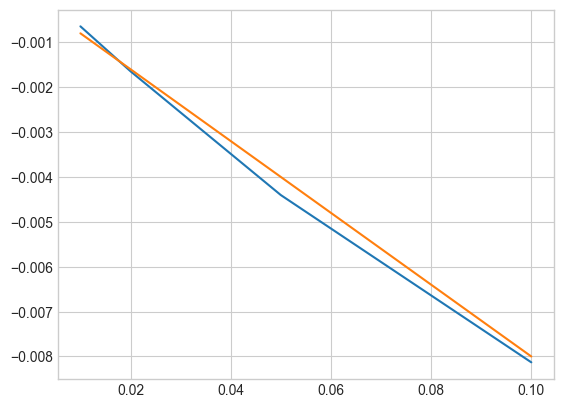

In [224]:
print(epsilons)
print(delta_means)
plt.plot(epsilons,delta_means)
plt.plot(epsilons,[-0.08*epsilon for epsilon in epsilons])
plt.show()

In [245]:
def chi_estimator(time:np.array, mean_trajectory: np.array, omega_p: float, A: float):
    # Parameter that defines number of periods as burn-in
    J = 10 
    total_time = time[-1]
    if omega_p != 0:
        period = (2*np.pi)/(omega_p)
    else:
        period = 20
    #define integration bounds (as integer multiples of whole periods)
    t0 = np.round(J*period, int(-np.log10(delta_t)))
    t_end = np.round(np.floor(total_time/period) * period, int(-np.log10(delta_t)))
    t0_index = int(t0/delta_t)
    t_end_index = int(t_end/delta_t)

    prefactor = 2/(A * (t_end - t0))
    integral_approx = 0
    
     # Create slices of the arrays for the integration range
    time_slice = time[t0_index:t_end_index]
    trajectory_slice = mean_trajectory[t0_index:t_end_index]

    # Perform the calculation on the entire array at once
    integrand = trajectory_slice * np.exp(-1j * omega_p * time_slice)
    
    # Sum the results and multiply by the time step
    integral_approx = np.sum(integrand) * delta_t

    chi_of_omega_p = prefactor * integral_approx

    return chi_of_omega_p


In [645]:
intermediate_storage = chi_estimators_list

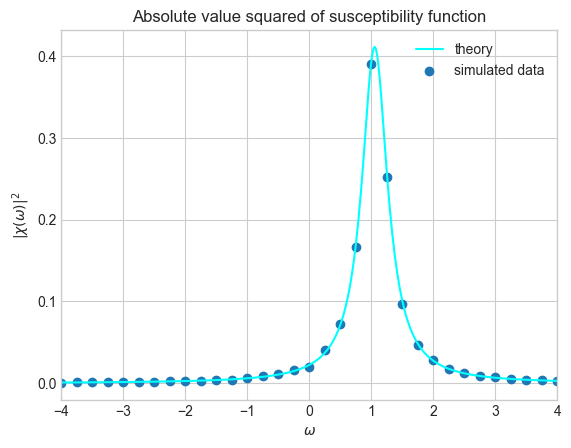

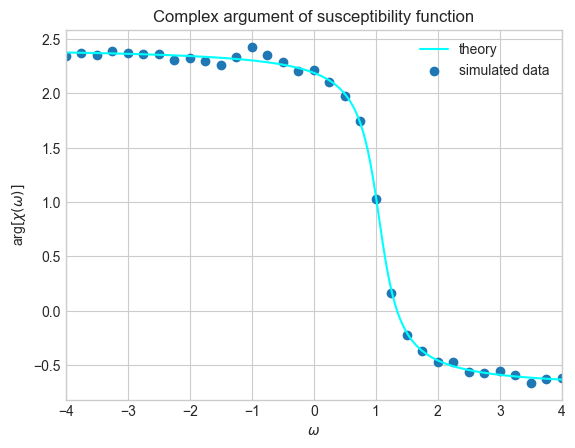

-1.0


In [644]:
### This section aims at calculating the linear response function and the susceptibility of the system for the first left hand eigenvector

# First we define the perturbation
# We want something like a sinusoidal modification of one transition rate
# We choose the last state of the first linear chain to be perturbed
perturbed_state_index = 9
def perturbation_force(t):
    return np.cos(t)
epsilon = 0.1
# Construct perturbation matrix
L_prime = np.zeros(np.shape(L))
L_prime[perturbed_state_index+1,perturbed_state_index] = 1
L_prime[perturbed_state_index,perturbed_state_index] = -1

# Since L_perturbed is now a time dependent linear transformation we have to define is as a function:
def L_perturbed(t):
    return epsilon * perturbation_force(t) * L_prime

# With that we can calculate the coefficient beta of the linear response function
beta = 0
for i in range(len(P[-1])):
    beta += Q[-2][i] * (L_prime @ P[-1])[i]


# The susceptibility is then defined by:
def chi(omega):
    return (beta)/(-eigenvals[-2].real + 1j * (omega-eigenvals[-2].imag))

def angle_chi(omega):
    return np.angle(beta) + np.arctan2(eigenvals[-2].imag - omega, -eigenvals[-2].real)

### -------
# Simulation:

# Parameters
N = 10
M = 10
number_of_substates = [N,M]
transition_rates = [1,1]
refractory_periods = [2,2]
total_time = 1000
delta_t = 0.01


### -------



# Plot abs valued squared of chi as well as complex argument
freq_space = np.linspace(-5,5,500)
abs_value_squared_chi_vals = [chi(omega) * np.conjugate(chi(omega)) for omega in freq_space]
complex_arg_chi_vals = [np.angle(chi(omega)) for omega in freq_space]

plt.plot(freq_space, abs_value_squared_chi_vals, color = 'cyan', label = 'theory')
plt.scatter(omega_p_list, chi_estimators_list*np.conjugate(chi_estimators_list), label='simulated data')
plt.xlim(-4,4)
plt.title('Absolute value squared of susceptibility function')
plt.xlabel('$\omega$')
plt.ylabel('$|\chi(\omega)|^2$')
plt.legend()
#plt.vlines(eigenvals[-2].imag, ymin=0, ymax=0.5).     #shows that susceptibility is maximal if perturbation has same frequency as system itself
plt.show()

plt.plot(freq_space, complex_arg_chi_vals, color = 'cyan', label = 'theory')
plt.scatter(omega_p_list, chi_estimator_phase_list, label = 'simulated data')
plt.xlim(-4,4)
plt.title('Complex argument of susceptibility function')
plt.xlabel('$\omega$')
plt.ylabel('arg$[\chi(\omega)]$')
plt.legend()
plt.show()

max_error_index = np.argmax(np.abs(np.array(chi_estimator_phase_list) - np.array([np.angle(chi(omega)) for omega in omega_p_list])))
print(omega_p_list[max_error_index])

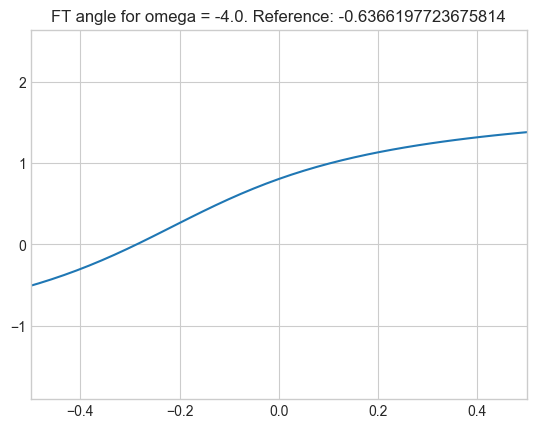

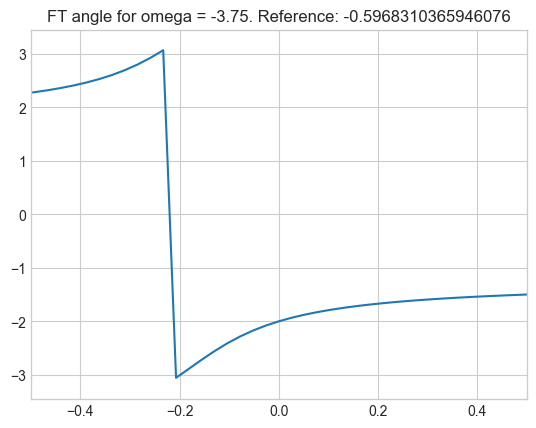

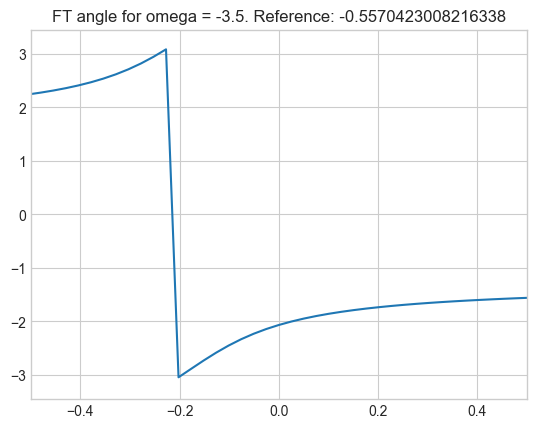

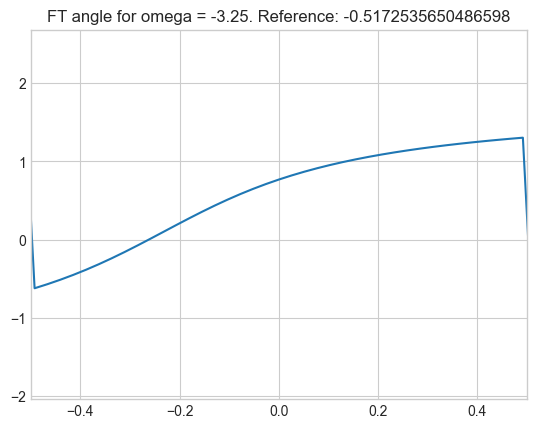

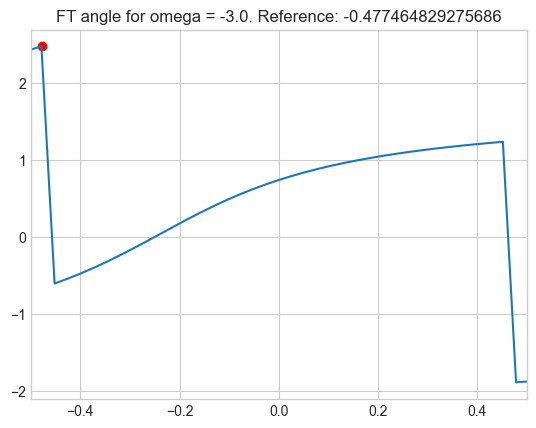

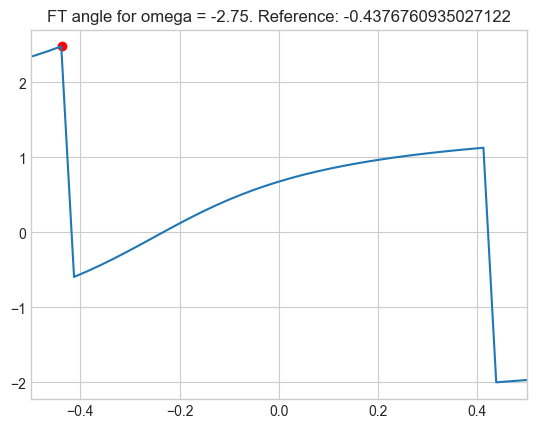

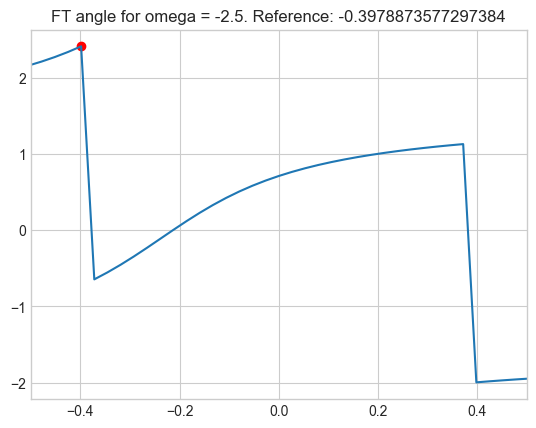

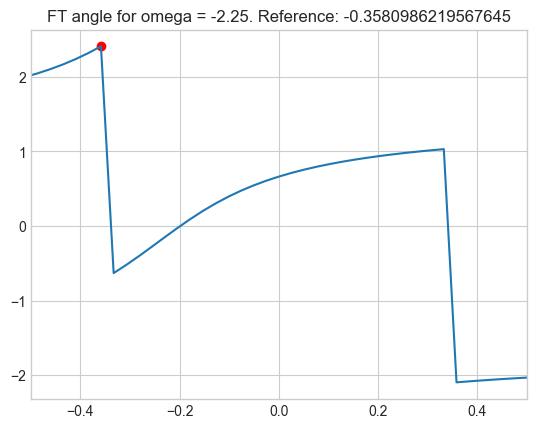

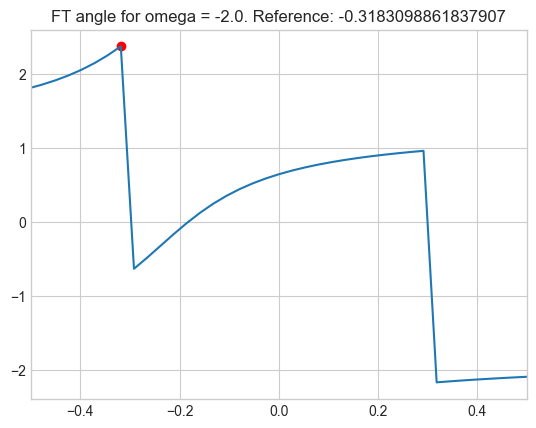

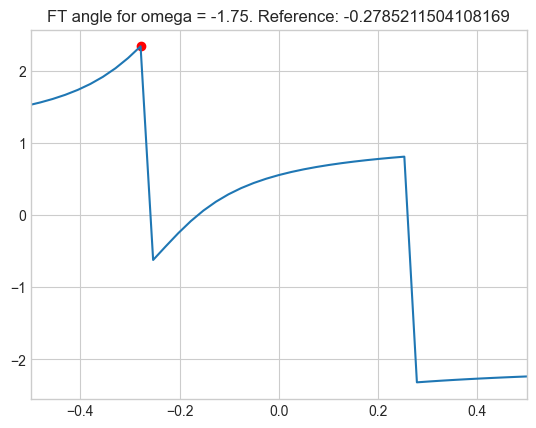

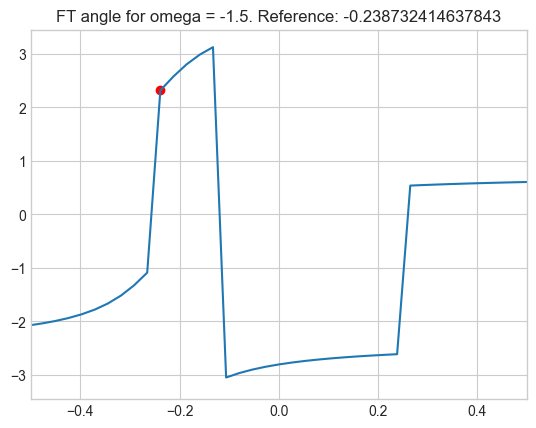

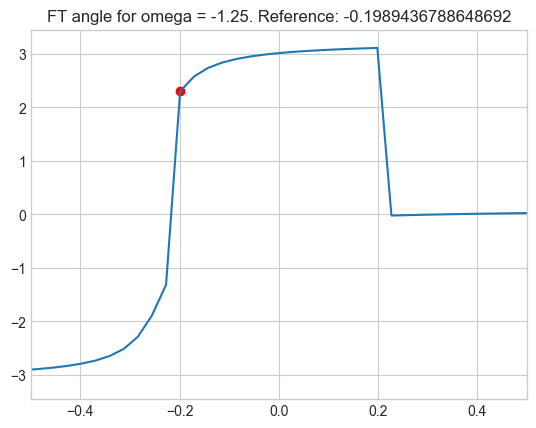

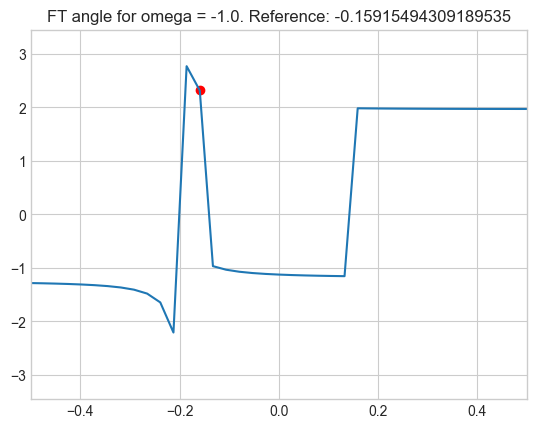

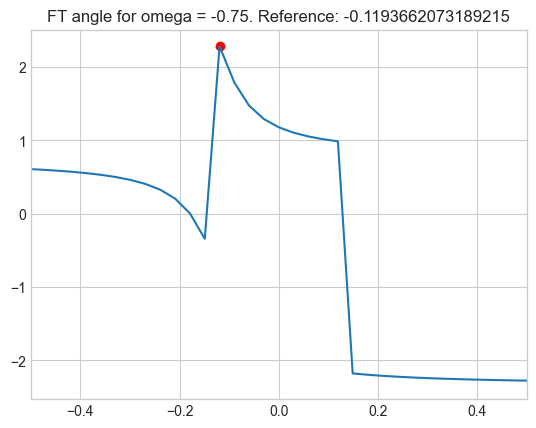

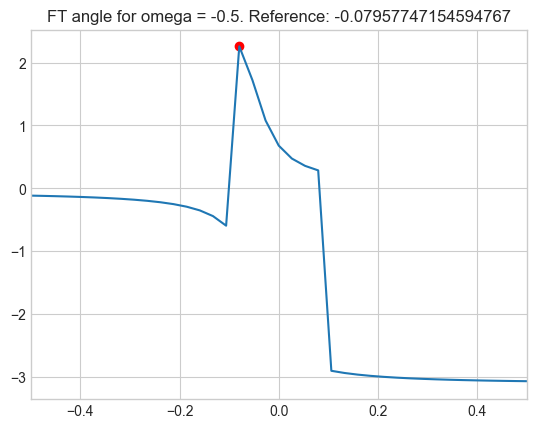

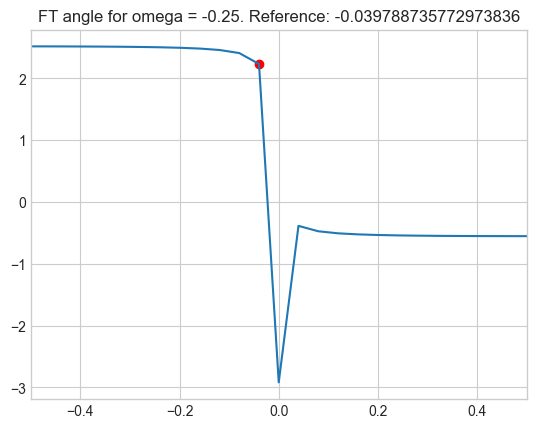

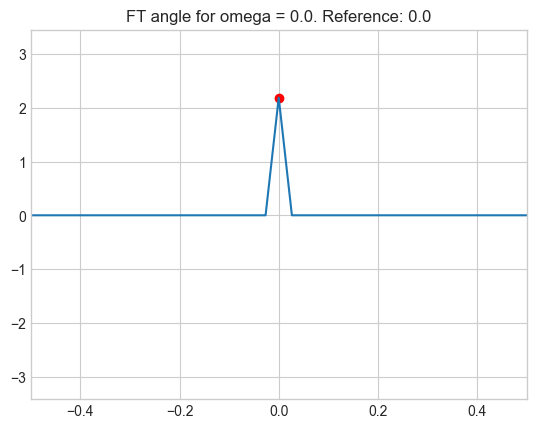

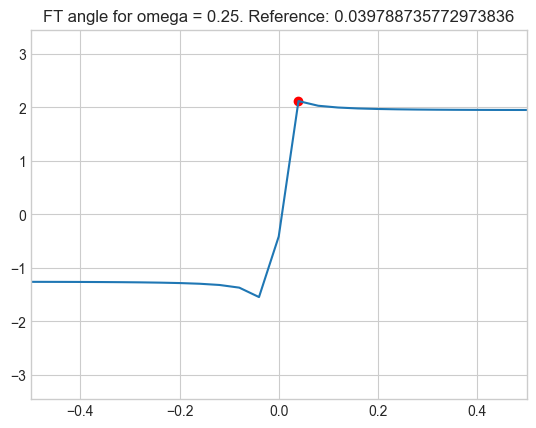

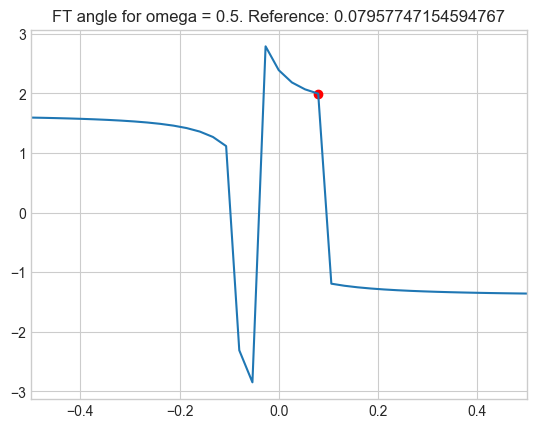

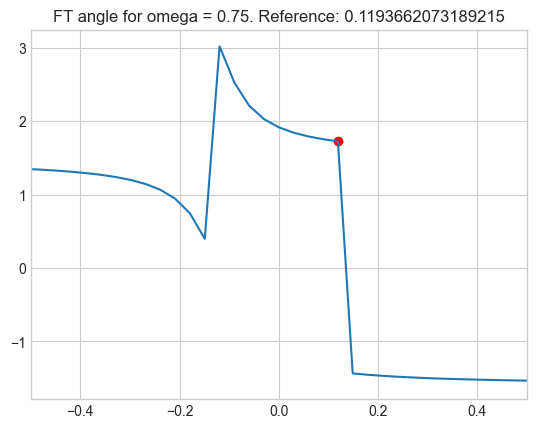

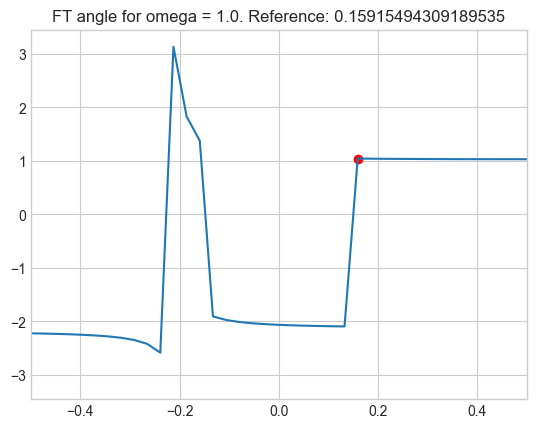

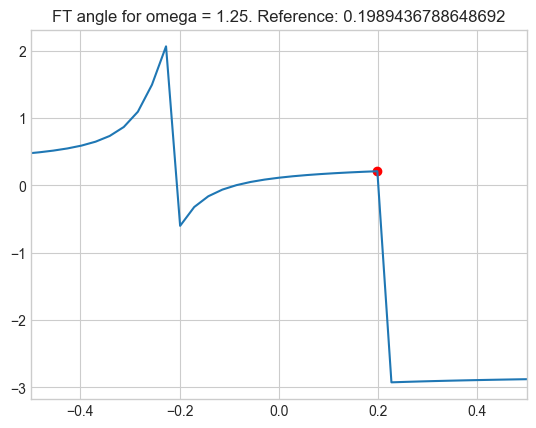

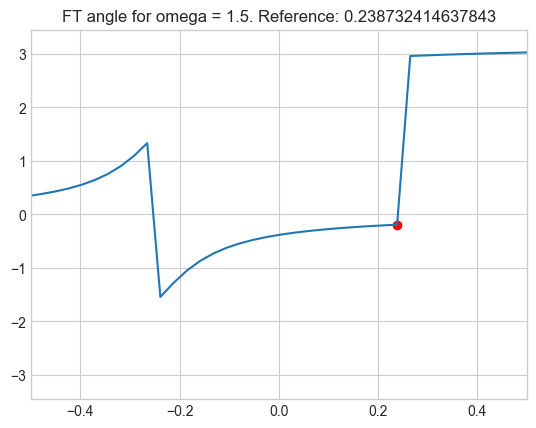

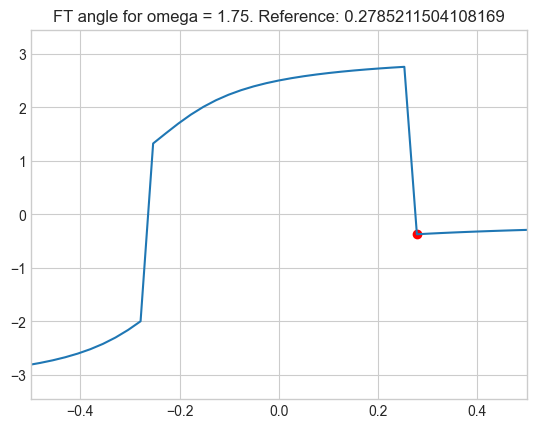

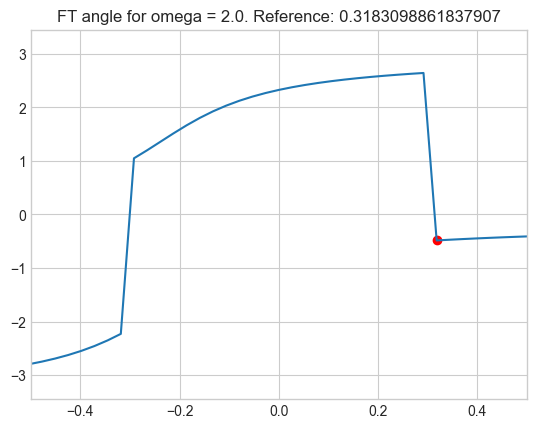

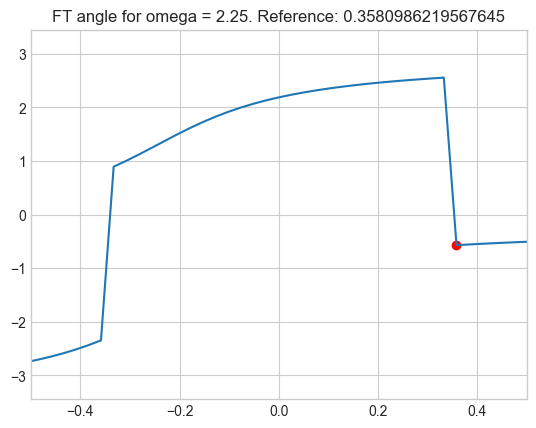

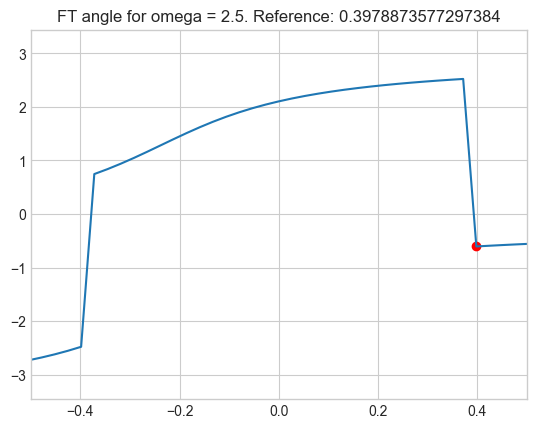

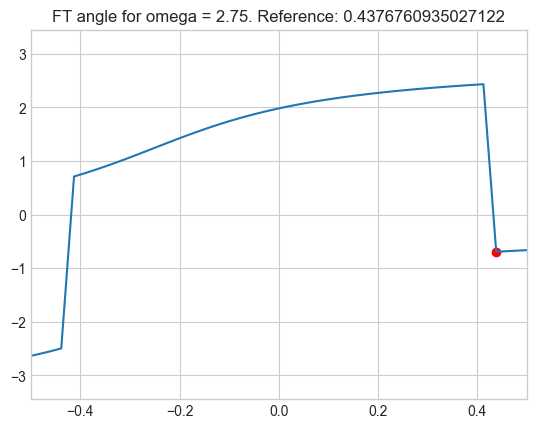

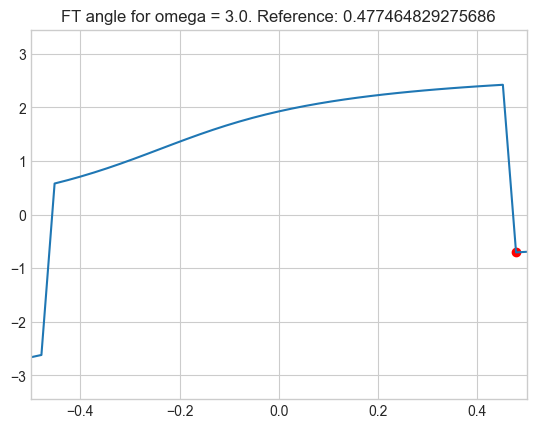

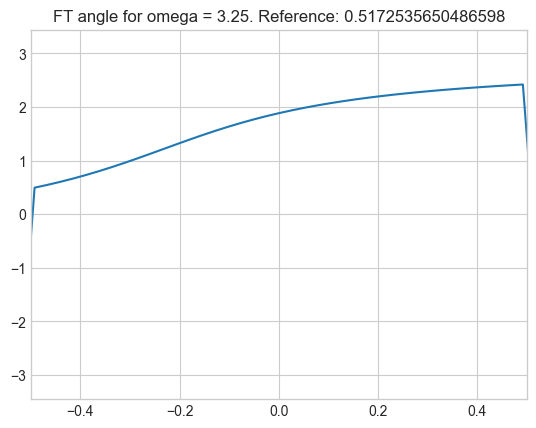

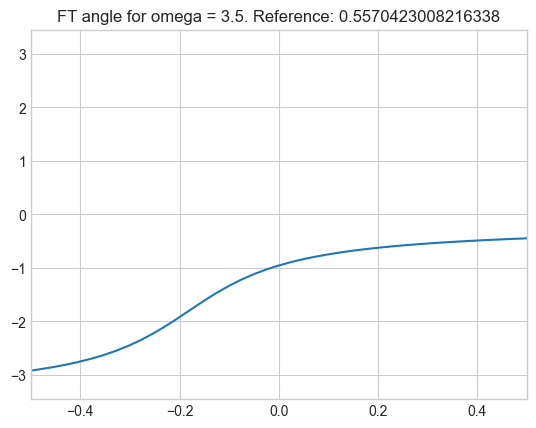

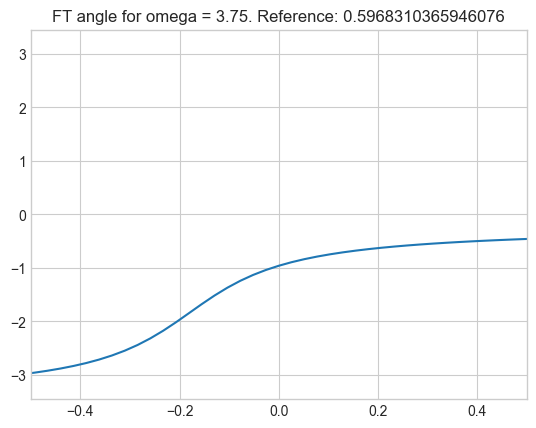

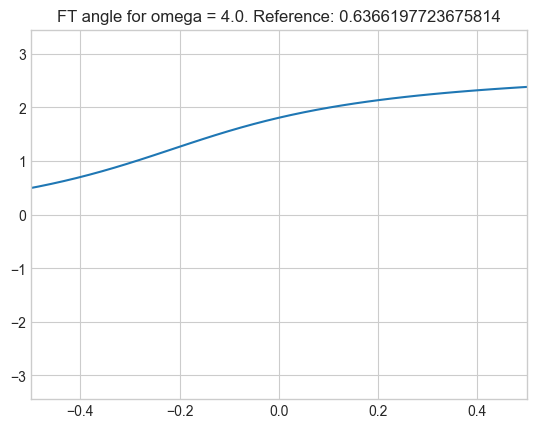

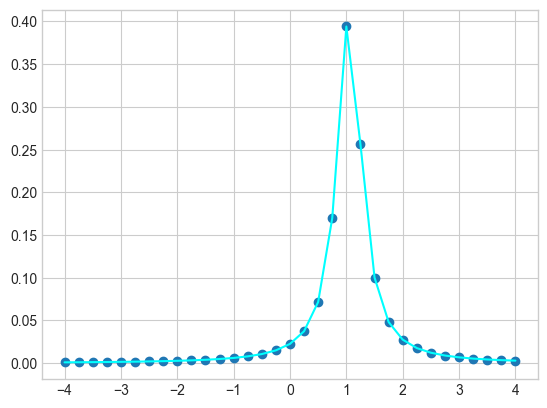

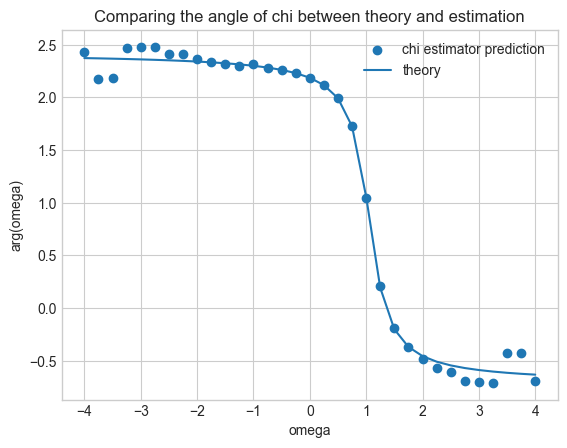

[-4.   -2.5  -2.25 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.
  0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   4.  ]


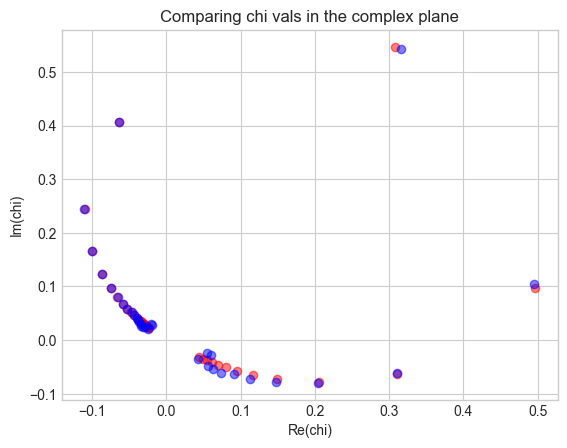

In [563]:
## sanity check for average value of Q_1
def time_avg_Q1(t,omega_p,epsilon):
    return epsilon/2 * (np.exp(1j*omega_p*t)*chi(omega_p) + np.exp(-1j* omega_p*t) * chi(-omega_p))

# sim params
total_time = 100
delta_t = 0.01
t = np.linspace(0,total_time,int(total_time/delta_t)+1)

omega_space = np.linspace(-4,4,33)
theory_chi_vals = []
theory_vals = []
for omega in omega_space:
    traj_mean_theory = np.array([time_avg_Q1(k,omega,0.1) for k in t])
    # truncate mean trajectory to start in stationary regime
    # also apply whole period window truncation for fourier transform to not show spectral leakage
    # windowing
    period_length = np.round(2*np.pi / np.abs(omega), int(-np.log10(delta_t))) if omega!= 0 else np.round(2*np.pi, int(-np.log10(delta_t)))
    window_length = np.round(100 * period_length, int(-np.log10(delta_t)))

    transient_time = np.round(10*(2*np.pi/(eigenvals[-2].imag)), int(-np.log10(delta_t)))  # let system settle
    transient_time_id = int(transient_time/delta_t)

    period_start_index = np.argmax(np.isclose(traj_mean_theory[transient_time_id:].real,np.zeros(len(t[transient_time_id:])),atol=0.0005))
    t_start = transient_time + t[period_start_index]
    t_start_id = int(t_start/delta_t)
    t_end = t_start + window_length if t_start + window_length <= total_time else t_start + np.round(np.floor((total_time-t_start)/period_length) * period_length, int(-np.log10(delta_t)))
    t_end_id = int(t_end/delta_t)

    window_length = t_end - t_start

    freqs = fftshift(fftfreq(len(traj_mean_theory[t_start_id:t_end_id]),delta_t))
    spectrum = fftshift(fft(traj_mean_theory[t_start_id:t_end_id])) * delta_t
    if omega != 0:
        spectrum = 2/(0.1*window_length) * spectrum
    else: 
        spectrum = 1/(0.1*window_length) * spectrum   # we have a different scaling factor for omega=0!!

    # output spectrum value of perturbation frequency
    f_p = omega/(2*np.pi)
    f_p_index = np.argmin(np.abs(f_p - freqs))
    response_p = spectrum[f_p_index]

    plt.plot(freqs,np.angle(spectrum*np.exp(-1j*(omega*t_start))))
    plt.scatter(f_p,np.angle(response_p*np.exp(-1j*(omega*t_start))), color='red')
    plt.title(f'FT angle for omega = {omega}. Reference: {f_p}')
    plt.xlim(-0.5,0.5)
    plt.show()

    theory_chi_vals.append(response_p*np.exp(-1j*(omega*t_start)))
    theory_vals.append(response_p*np.conj(response_p))

plt.scatter(omega_space,theory_vals)
plt.plot(omega_space,[chi(omega)*np.conjugate(chi(omega)) for omega in omega_space], color='cyan')
plt.show()

# check if relative phase is working
theory_chi_vals = np.array(theory_chi_vals)
plt.scatter(omega_space, np.angle(theory_chi_vals), label='chi estimator prediction')
plt.plot(omega_space, [np.angle(chi(omega)) for omega in omega_space], label='theory')
plt.title('Comparing the angle of chi between theory and estimation')
plt.xlabel('omega')
plt.ylabel('arg(omega)')
plt.legend()
plt.show()

close_points = np.isclose(np.angle(theory_chi_vals), [np.angle(chi(omega)) for omega in omega_space], atol=0.1)
print(omega_space[close_points])


theory_chi_vals = np.array(theory_chi_vals)
plt.scatter(np.array([chi(omega) for omega in omega_space]).real, np.array([chi(omega) for omega in omega_space]).imag, alpha=0.5, color = 'red', label='theory')
plt.scatter(theory_chi_vals.real, theory_chi_vals.imag, alpha=0.5, color='blue', label='chi estimator prediction')
plt.title('Comparing chi vals in the complex plane')
plt.xlabel('Re(chi)')
plt.ylabel('Im(chi)')
plt.show()




The considered time window is 59.69 to 1630.49, i.e. a total duration of 1570.8.
Thus the sampling spacing in frequency space should be 0.0006366182836771072.


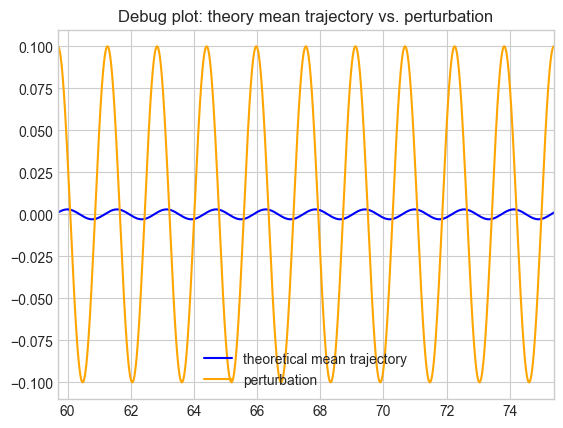

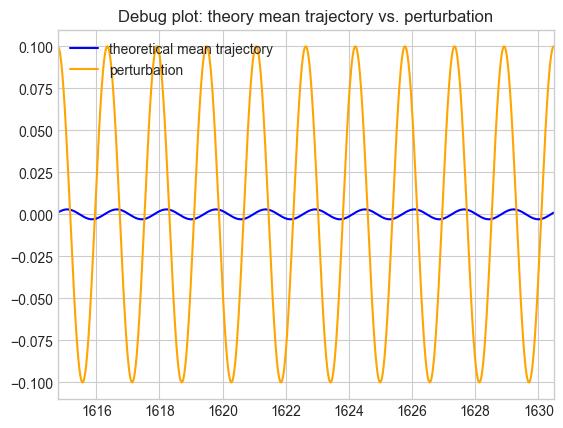

The frequency samples at f_p and f_p + delta f are :-0.6366182836771073, -0.6359816653934302. Thus the actual spacing is 0.000636618283677115.
The actual perturbation frequency f_p hoever is: -0.6366197723675814.


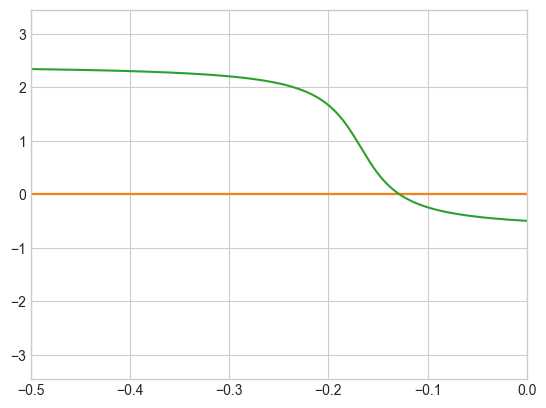

The error in the phase were dealing with is : 0.0073465807639232494.
The considered time window is 59.69 to 1999.1000000000001, i.e. a total duration of 1939.41.
Thus the sampling spacing in frequency space should be 0.0005156207300158295.


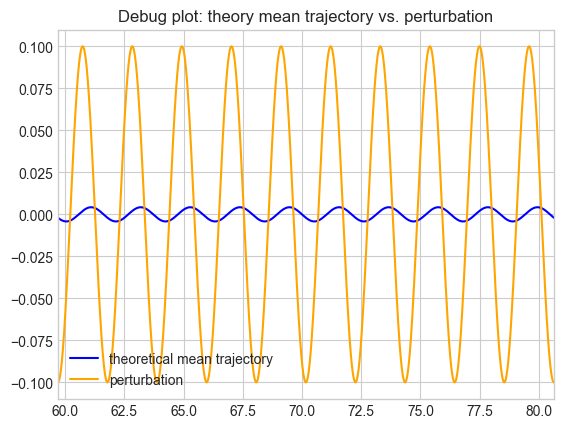

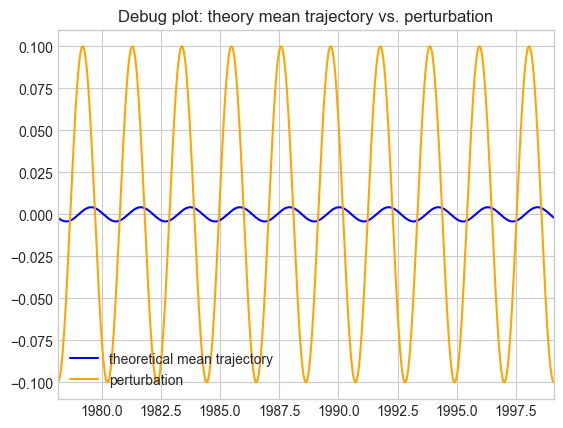

The frequency samples at f_p and f_p + delta f are :-0.47746479599465813, -0.4769491752646423. Thus the actual spacing is 0.00051562073001582.
The actual perturbation frequency f_p hoever is: -0.477464829275686.


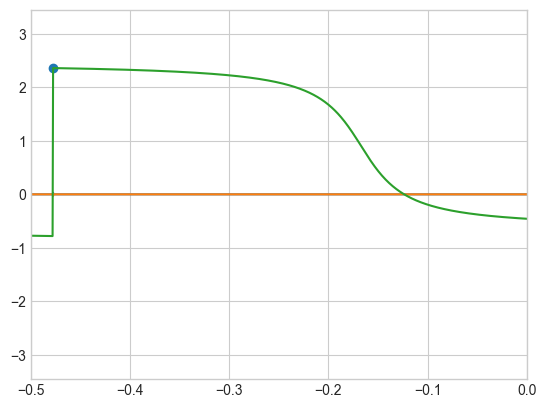

The error in the phase were dealing with is : 0.0050244490298387845.
The considered time window is 60.53 to 1998.8899999999999, i.e. a total duration of 1938.36.
Thus the sampling spacing in frequency space should be 0.000515900039208403.


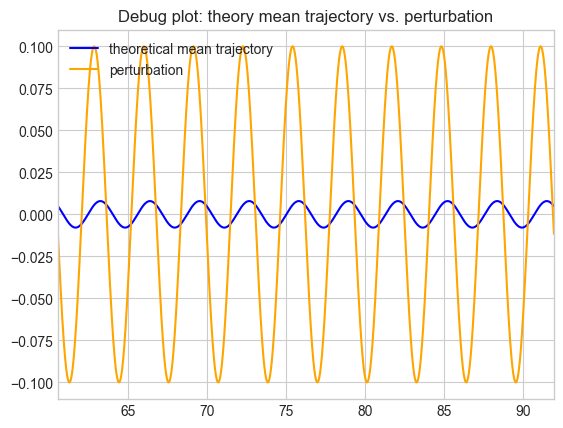

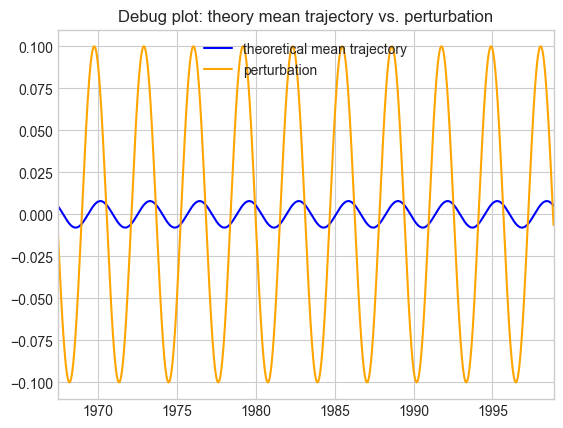

The frequency samples at f_p and f_p + delta f are :-0.3183119663631439, -0.31779606366239327. Thus the actual spacing is 0.0005159027007506367.
The actual perturbation frequency f_p hoever is: -0.3183098861837907.


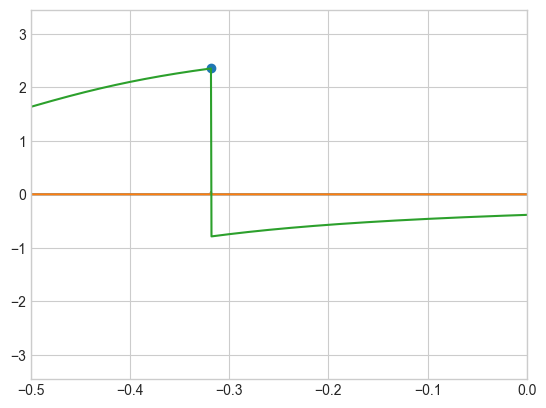

The error in the phase were dealing with is : 0.02545665384784801.
The considered time window is 60.0 to 1995.22, i.e. a total duration of 1935.22.
Thus the sampling spacing in frequency space should be 0.0005167371151600335.


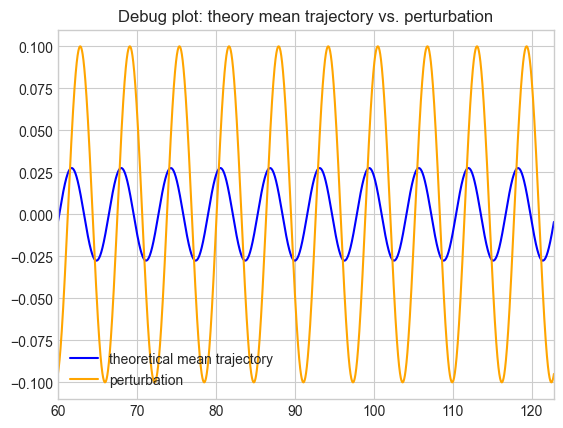

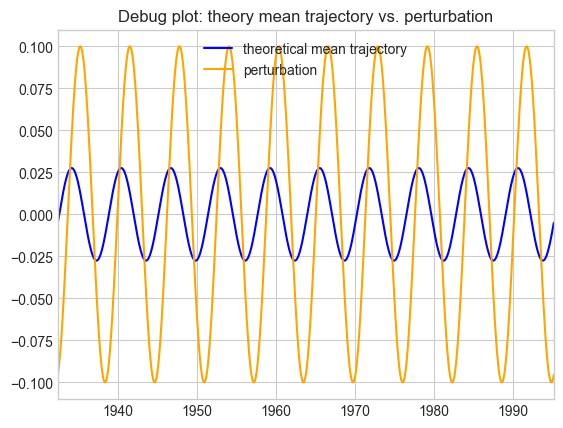

The frequency samples at f_p and f_p + delta f are :-0.1591550314692903, -0.1586382943541303. Thus the actual spacing is 0.0005167371151600098.
The actual perturbation frequency f_p hoever is: -0.15915494309189535.


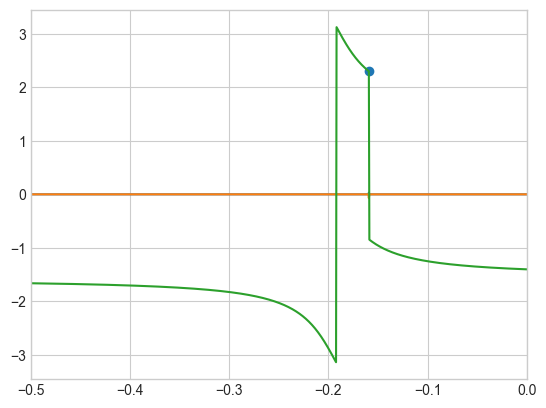

The error in the phase were dealing with is : 0.06557778550839188.
1993.93
The considered time window is 59.69 to 1993.93, i.e. a total duration of 1934.24.
Thus the sampling spacing in frequency space should be 0.0005169989246422368.


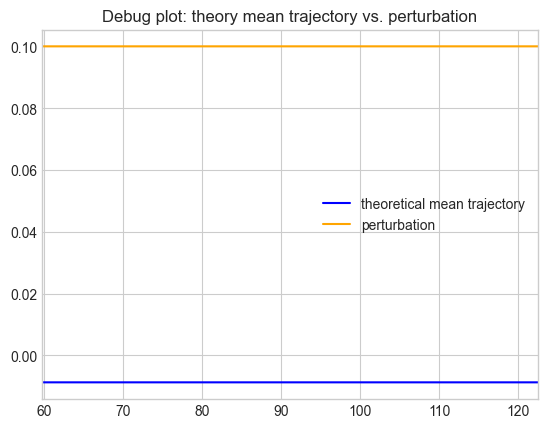

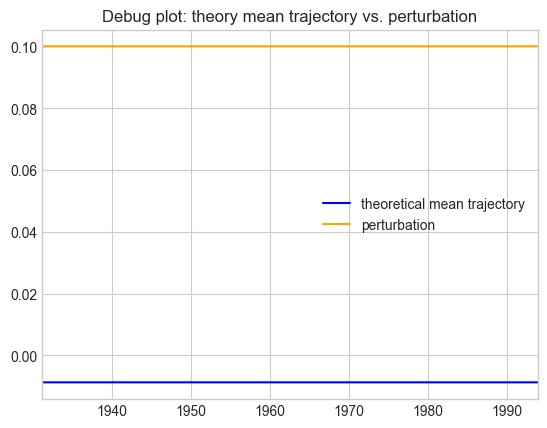

The frequency samples at f_p and f_p + delta f are :0.0, 0.0005169989246422368. Thus the actual spacing is 0.0005169989246422368.
The actual perturbation frequency f_p hoever is: 0.0.


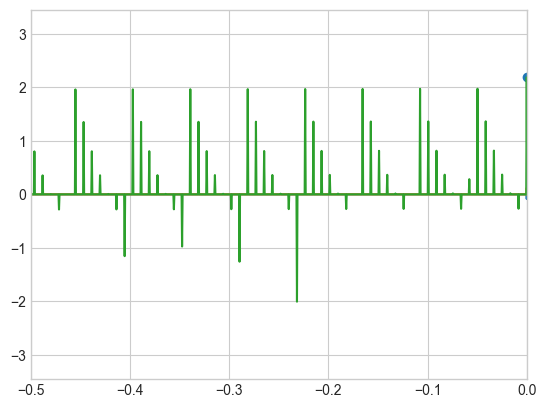

The error in the phase were dealing with is : 0.17928309784858376.
The considered time window is 60.0 to 1995.22, i.e. a total duration of 1935.22.
Thus the sampling spacing in frequency space should be 0.0005167371151600335.


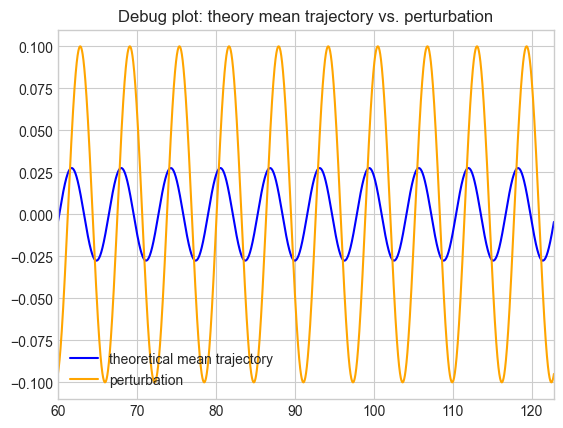

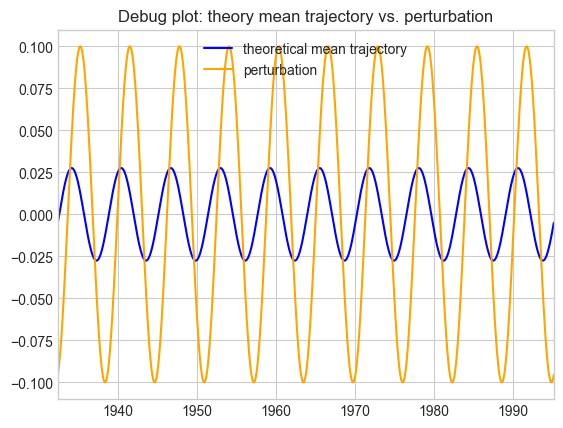

The frequency samples at f_p and f_p + delta f are :0.1591550314692903, 0.15967176858445034. Thus the actual spacing is 0.0005167371151600375.
The actual perturbation frequency f_p hoever is: 0.15915494309189535.


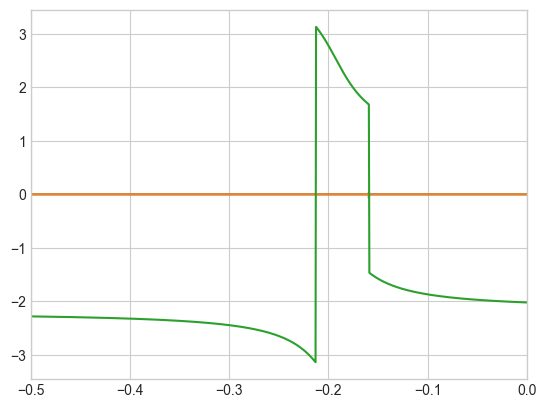

The error in the phase were dealing with is : 1.3088503097736843.
The considered time window is 60.53 to 1998.8899999999999, i.e. a total duration of 1938.36.
Thus the sampling spacing in frequency space should be 0.000515900039208403.


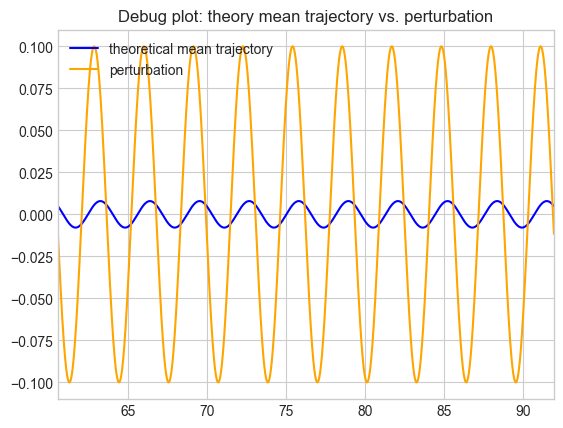

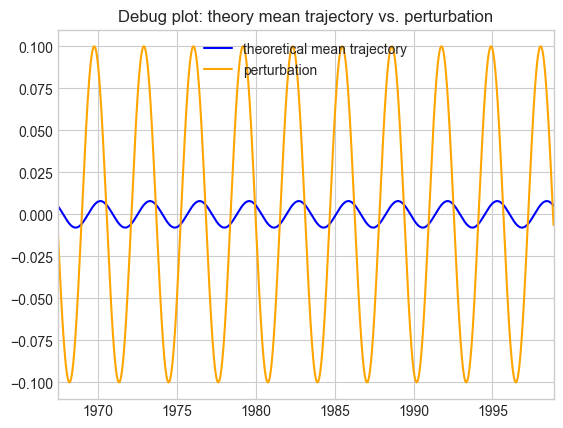

The frequency samples at f_p and f_p + delta f are :0.3183119663631439, 0.31882786906389454. Thus the actual spacing is 0.0005159027007506367.
The actual perturbation frequency f_p hoever is: 0.3183098861837907.


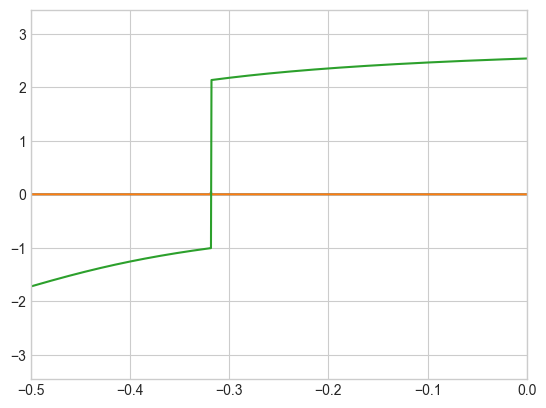

The error in the phase were dealing with is : 2.82190409220505.
The considered time window is 59.69 to 1999.1000000000001, i.e. a total duration of 1939.41.
Thus the sampling spacing in frequency space should be 0.0005156207300158295.


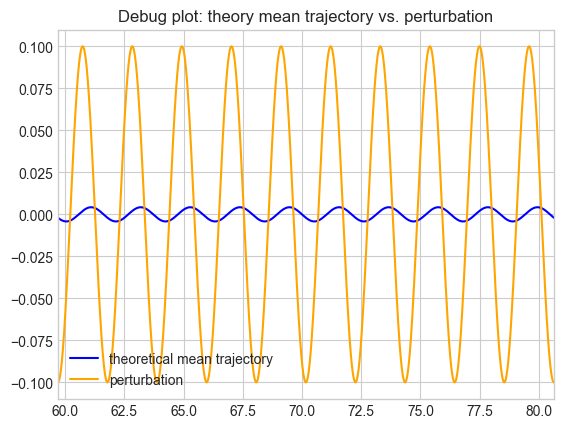

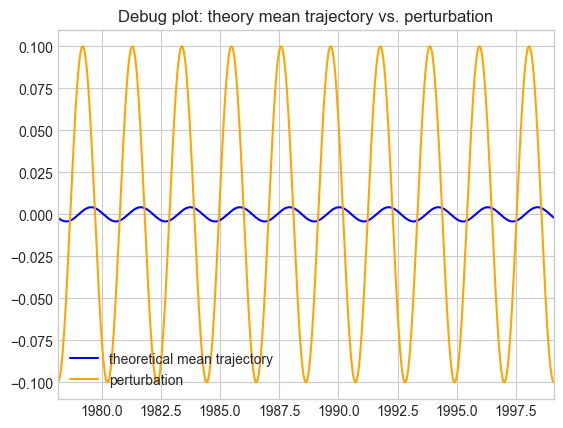

The frequency samples at f_p and f_p + delta f are :0.47746479599465813, 0.47798041672467395. Thus the actual spacing is 0.00051562073001582.
The actual perturbation frequency f_p hoever is: 0.477464829275686.


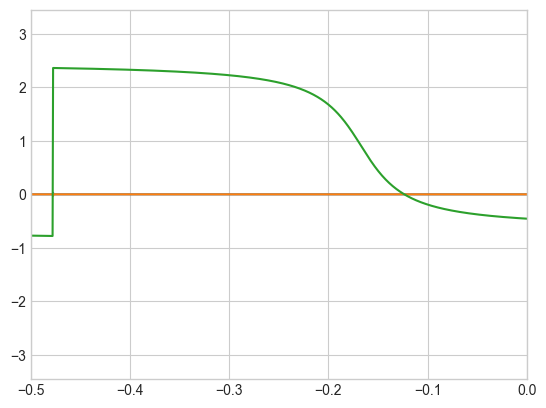

The error in the phase were dealing with is : 2.954223696635694.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


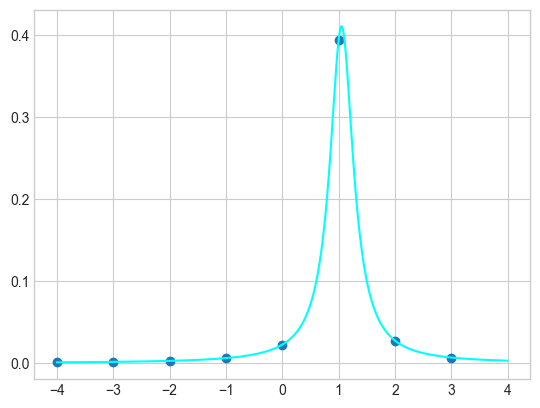

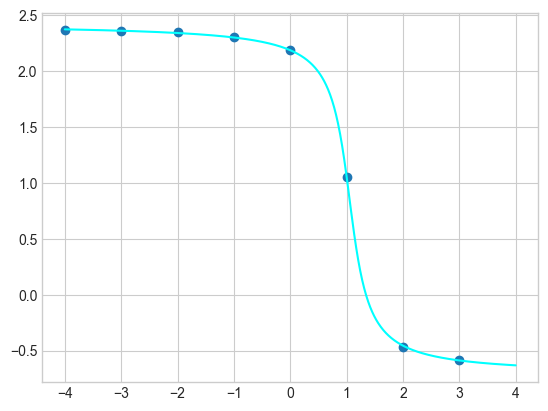

In [603]:
## sanity check for average value of Q_1
def time_avg_Q1(t,omega_p,epsilon):
    return epsilon/2 * (np.exp(1j*omega_p*t)*chi(omega_p) + np.exp(-1j* omega_p*t) * chi(-omega_p))


# sim params
total_time = 2000
delta_t = 0.01
t = np.linspace(0,total_time,int(total_time/delta_t)+1)

omega_space = [-4,-3,-2,-1,0,1,2,3]
theory_vals = []
theory_chi_vals = []
for omega in omega_space:
    traj_mean_theory = np.array([time_avg_Q1(k,omega,0.1) for k in t])
    # truncate mean trajectory to start in stationary regime
    # also apply whole period window truncation for fourier transform to not show spectral leakage
    period_length = 2*np.pi / np.abs(omega) if omega!= 0 else np.round(2*np.pi, int(-np.log10(delta_t)))
    window_length = np.round(1000 * period_length, int(-np.log10(delta_t)))

    transient_time = np.round(10*(2*np.pi/(eigenvals[-2].imag)), int(-np.log10(delta_t)))  # let system settle
    transient_time_id = int(transient_time/delta_t)

    period_start_index_traj = np.argmax(np.isclose(traj_mean_theory[transient_time_id:].real,np.zeros(len(t[transient_time_id:])),atol=0.005))
    period_start_index_pert = np.argmax(np.isclose([p(k,omega,epsilon=0.1) for k in t][transient_time_id:],np.full(len(t[transient_time_id:]),np.max(traj_mean_theory)),atol=0.0005))
    t_start_pert = transient_time + t[period_start_index_pert]
    t_start_pert_id = int(t_start_pert/delta_t)
    t_start = transient_time + t[period_start_index_traj]
    t_start_id = int(t_start/delta_t)
    t_end = t_start + window_length if t_start + window_length <= total_time else t_start + np.round(np.floor((total_time-t_start)/period_length) * period_length, int(-np.log10(delta_t)))
    if omega == 0:
        print(t_end)
    t_end_id = int(t_end/delta_t)

    window_length = t_end - t_start

    print(f'The considered time window is {t_start} to {t_end}, i.e. a total duration of {window_length}.')
    print(f'Thus the sampling spacing in frequency space should be {1/window_length}.')

    plt.plot(t[t_start_id:t_end_id], traj_mean_theory[t_start_id:t_end_id], color='blue', label='theoretical mean trajectory')
    plt.plot(t[t_start_id:t_end_id], [p(k,omega,epsilon=0.1) for k in t][t_start_id:t_end_id], color='orange', label='perturbation')
    plt.xlim(t_start, 10*period_length + t_start)
    plt.title('Debug plot: theory mean trajectory vs. perturbation')
    plt.legend()
    plt.show()

    plt.plot(t[t_start_id:t_end_id], traj_mean_theory[t_start_id:t_end_id], color='blue', label='theoretical mean trajectory')
    plt.plot(t[t_start_id:t_end_id], [p(k,omega,epsilon=0.1) for k in t][t_start_id:t_end_id], color='orange', label='perturbation')
    plt.xlim(t_end - 10*period_length, t_end)
    plt.title('Debug plot: theory mean trajectory vs. perturbation')
    plt.legend()
    plt.show()

    freqs = fftshift(fftfreq(len(traj_mean_theory[t_start_id:t_end_id]),delta_t))
    spectrum = fftshift(fft(traj_mean_theory[t_start_id:t_end_id])) * delta_t


    # Modified spectrum to fit estimator for chi
    if omega != 0:
        spectrum = 2/(0.1*window_length) * spectrum
    else: 
        spectrum = 1/(0.1*window_length) * spectrum   # we have a different scaling factor for omega=0!!

    # output spectrum value of perturbation frequency
    f_p = omega/(2*np.pi)
    f_p_index = np.argmin(np.abs(f_p - freqs))
    response_p = spectrum[f_p_index]

    plt.plot(freqs, spectrum.real)
    plt.plot(freqs, spectrum.imag)
    #plt.xlim(-1,1)
    #plt.show()
    print(f'The frequency samples at f_p and f_p + delta f are :{freqs[f_p_index]}, {freqs[f_p_index + 1]}. Thus the actual spacing is {freqs[f_p_index + 1]-freqs[f_p_index]}.')
    print(f'The actual perturbation frequency f_p hoever is: {f_p}.')

    plt.plot(freqs,np.angle(spectrum*np.exp(-1j*(omega*t_start))))
    plt.scatter(f_p,np.angle(response_p*np.exp(-1j*(omega*t_start))))
    plt.xlim(-0.5,0)
    plt.show()

    theory_vals.append(response_p*np.conj(response_p))
    theory_chi_vals.append(np.angle(response_p*np.exp(-1j*(omega*t_start))))

    phase_error = np.angle(response_p*np.exp(-1j*(omega*t_start))/chi(-omega))

    print(f'The error in the phase were dealing with is : {np.abs(theory_chi_vals[0] - np.angle(chi(omega)))}.' )

plt.scatter(omega_space,theory_vals)
plt.plot(np.linspace(-4,4,900),[chi(omega)*np.conjugate(chi(omega)) for omega in np.linspace(-4,4,900)], color='cyan')
plt.show()

plt.scatter(omega_space, theory_chi_vals)
plt.plot(np.linspace(-4,4,900), [np.angle(chi(omega)) for omega in np.linspace(-4,4,900)], color='cyan')
plt.show()


--- Starting Robust FFT Analysis (v3) ---

Processing omega = -0.75 rad/s
Transient time 59.69s. Finding next zero-crossing...
Window will start at t_start = 62.34s (index 6234)
Window duration T = 327.68 s. (Freq. spacing = 0.00305 Hz)
Target freq f_p = -0.1194 Hz. Closest bin = -0.1190 Hz
Measured Phase (Corrected): 1.9262 rad
Theory Phase:             2.2841 rad
PHASE ERROR:              -0.3579 rad


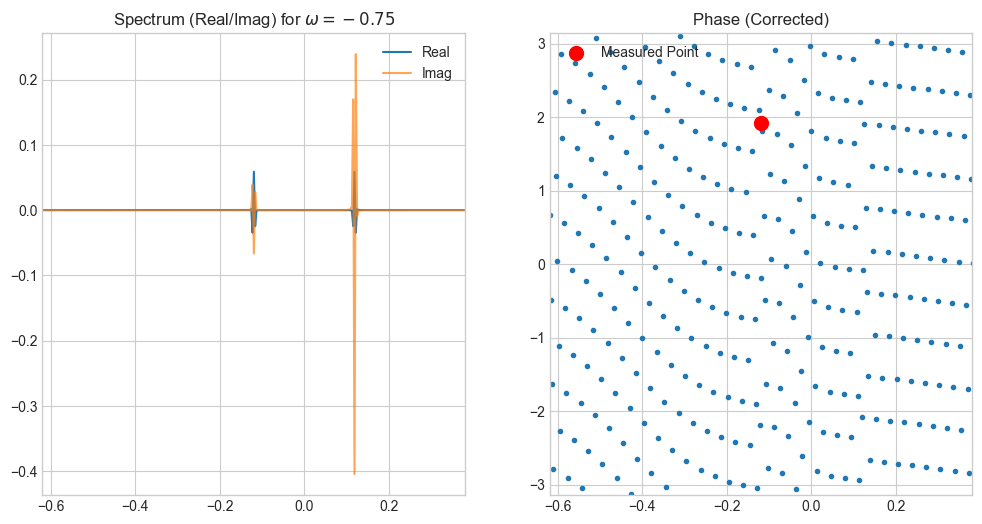


Final Phase Errors: [-0.35787499741152173]


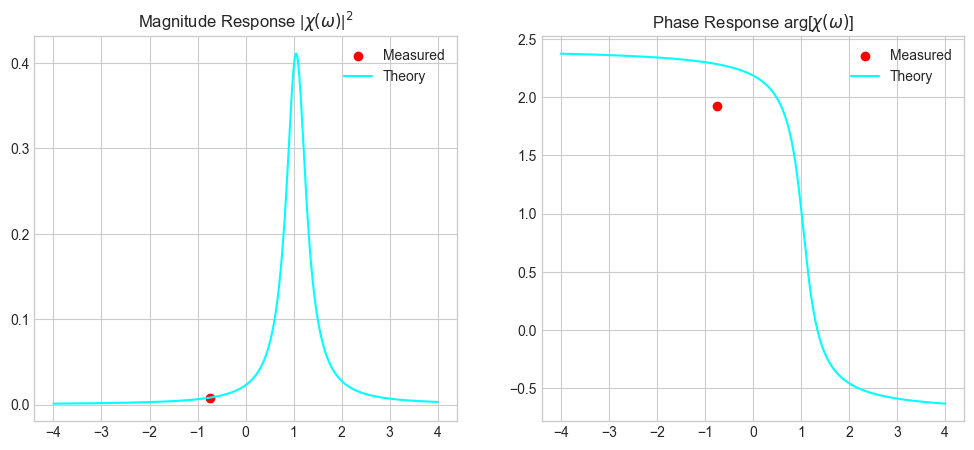

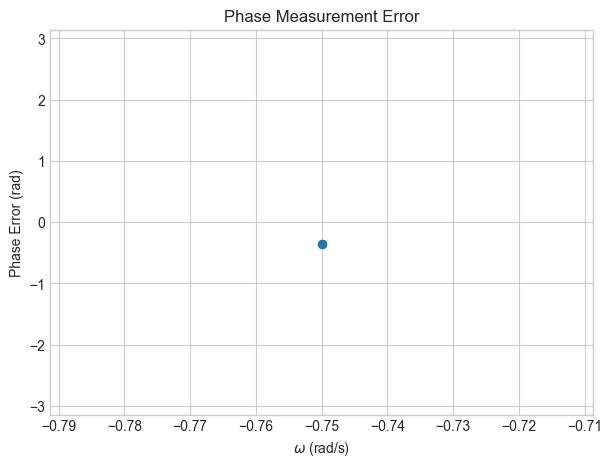

In [510]:
from scipy.signal import windows

## sanity check for average value of Q_1
def time_avg_Q1(t, omega_p, epsilon):
    # This function is unchanged. We analyze the signal it produces.
    return epsilon/2 * (np.exp(1j*omega_p*t)*chi(omega_p) + np.exp(-1j* omega_p*t) * chi(-omega_p))

# sim params
total_time = 1000
delta_t = 0.01
t = np.linspace(0, total_time, int(total_time/delta_t)+1)
epsilon = 0.1
omega_space = [-0.75]
theory_vals = []
theory_chi_vals = []
phase_error_list = []

print("--- Starting Robust FFT Analysis (v3) ---")

for omega in omega_space:
    print(f"\nProcessing omega = {omega} rad/s")
    
    # 1. Generate Signal
    traj_mean_theory = np.array([time_avg_Q1(k, omega, epsilon) for k in t])
    
    # 2. ### RESTORED & FIXED: Find Steady-State + Zero-Crossing
    transient_time = np.round(10 * (2 * np.pi / (np.abs(eigenvals[-2].imag))), int(-np.log10(delta_t)))
    transient_time_id = int(transient_time / delta_t)

    # Find the *relative* index of the first zero-crossing *after* the transient time
    relative_start_index = np.argmax(
        np.isclose(traj_mean_theory[transient_time_id:].real, 0, atol=0.0005)
    )
    
    # The *absolute* index in the 't' and 'traj_mean_theory' arrays
    t_start_id = transient_time_id + relative_start_index
    
    # The actual time (in seconds) where our window starts
    t_start = t[t_start_id] 
    
    print(f"Transient time {transient_time}s. Finding next zero-crossing...")
    print(f"Window will start at t_start = {t_start}s (index {t_start_id})")

    # 3. ### KEPT: Fixed Window + Hann
    N_window = 2**15  # 32768 samples
    t_end_id = t_start_id + N_window

    if t_end_id > len(traj_mean_theory):
        N_window = len(traj_mean_theory) - t_start_id
        t_end_id = t_start_id + N_window
        print(f"Warning: Not enough data. Using shorter window: {N_window} samples")

    signal_snippet = traj_mean_theory[t_start_id:t_end_id]
    win = windows.hann(N_window)
    signal_prepared = signal_snippet * win
    
    T_window = N_window * delta_t
    print(f"Window duration T = {T_window:.2f} s. (Freq. spacing = {1/T_window:.5f} Hz)")

    # 4. Calculate FFT
    freqs = fftshift(fftfreq(N_window, delta_t))
    spectrum_raw = fftshift(fft(signal_prepared))

    # 5. Scaling Logic
    # chi(omega) = FFT_peak / ( (epsilon/2) * win.sum() )
    measured_chi_spectrum = spectrum_raw / (win.sum() * (epsilon / 2.0))

    # 6. Find Measurement
    f_p = omega / (2 * np.pi)
    f_p_index = np.argmin(np.abs(f_p - freqs))
    measured_chi_at_f_p = measured_chi_spectrum[f_p_index]
    
    print(f"Target freq f_p = {f_p:.4f} Hz. Closest bin = {freqs[f_p_index]:.4f} Hz")
    
    # 7. ### UPDATED: Apply Phase Correction
    # We must correct for starting our FFT window at 't_start'
    corrected_chi = measured_chi_at_f_p * np.exp(-1j * (omega * t_start))

    # 8. Store Results and Calculate Error
    theoretical_chi = chi(omega)
    phase_error = np.angle(corrected_chi / theoretical_chi)
    
    theory_vals.append(np.abs(corrected_chi)**2)
    theory_chi_vals.append(np.angle(corrected_chi))
    phase_error_list.append(phase_error)
    
    print(f"Measured Phase (Corrected): {np.angle(corrected_chi):.4f} rad")
    print(f"Theory Phase:             {np.angle(theoretical_chi):.4f} rad")
    print(f"PHASE ERROR:              {phase_error:.4f} rad")
    
    # --- Debug Plots (Unchanged) ---
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Spectrum (Real/Imag) for $\omega={omega}$")
    plt.plot(freqs, measured_chi_spectrum.real, label="Real")
    plt.plot(freqs, measured_chi_spectrum.imag, label="Imag", alpha=0.7)
    plt.xlim(f_p - 0.5, f_p + 0.5) # Zoom in
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Phase (Corrected)")
    plt.plot(freqs, np.angle(measured_chi_spectrum * np.exp(-1j * (freqs * 2 * np.pi * t_start_correction))), '.')
    plt.scatter(f_p, np.angle(corrected_chi), color='red', s=100, zorder=5, label="Measured Point")
    plt.xlim(f_p - 0.5, f_p + 0.5) # Zoom in
    plt.ylim(-np.pi, np.pi)
    plt.legend()
    plt.show()

# --- Final Results Plots ---
print(f"\nFinal Phase Errors: {phase_error_list}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Magnitude Response |$\chi(\omega)$|$^2$")
plt.scatter(omega_space, theory_vals, label="Measured", c='red')
plt.plot(np.linspace(-4, 4, 900), [np.abs(chi(om))**2 for om in np.linspace(-4, 4, 900)], color='cyan', label="Theory")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Phase Response arg[$\chi(\omega)$]")
plt.scatter(omega_space, theory_chi_vals, label="Measured", c='red')
plt.plot(np.linspace(-4, 4, 900), [np.angle(chi(om)) for om in np.linspace(-4, 4, 900)], color='cyan', label="Theory")
plt.legend()
plt.show()

# The most important plot:
plt.figure(figsize=(7, 5))
plt.title("Phase Measurement Error")
plt.scatter(omega_space, phase_error_list)
plt.ylabel("Phase Error (rad)")
plt.xlabel("$\omega$ (rad/s)")
plt.ylim(-np.pi, np.pi)
plt.grid(True)
plt.show()

(-6.1184859915507676e-06-6.896182135894297e-07j)
The theoretical phase shift is 1.671460697750701.
I.e. 95.7676436031069 degree.


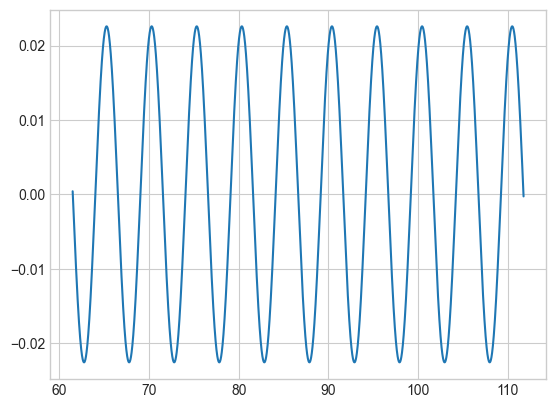

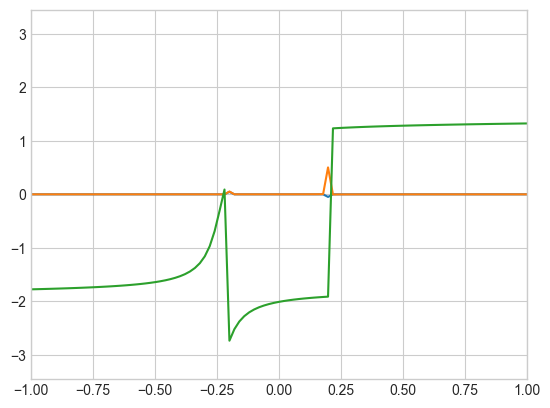

(-0.04831975492400659+0.5039500364050352j)
0.21460983175712944


In [497]:
def time_avg_Q1(t,omega_p,epsilon):
    return epsilon/2 * (np.exp(1j*omega_p*t)*chi(omega_p) + np.exp(-1j* omega_p*t) * chi(-omega_p))

omega_space = [1.25]
theory_vals = []
for omega in omega_space:
    traj_mean_theory = np.array([time_avg_Q1(k,omega,0.1) for k in t])
    print(np.mean(traj_mean_theory))

    # Calculate theoretical phase shift
    phi = np.arctan2(chi(omega).real + chi(-omega).real, -chi(omega).imag + chi(-omega).imag)
    print(f'The theoretical phase shift is {phi}.')
    print(f'I.e. {phi/(2*np.pi) * 360} degree.')
    def theoretical_oscillation(t, omega):
        amplitude = epsilon/2 * np.sqrt((chi(omega).real + chi(-omega).real)**2 + (-chi(omega).imag + chi(-omega))**2)
        return amplitude * np.sin(omega*t + phi)

    # windowing
    period_length = np.round(2*np.pi / omega, int(-np.log10(delta_t))) if omega!= 0 else np.round(2*np.pi, int(-np.log10(delta_t)))
    window_length = np.round(10 * period_length, int(-np.log10(delta_t)))

    transient_time = np.round(10*(2*np.pi/(eigenvals[-2].imag)), int(-np.log10(delta_t)))  # let system settle
    transient_time_id = int(transient_time/delta_t)

    period_start_index = np.argmax(np.isclose(traj_mean_theory[transient_time_id:].real,np.zeros(len(t[transient_time_id:])),atol=0.0005))
    t_start = transient_time + t[period_start_index]
    t_start_id = int(t_start/delta_t)
    t_end = t_start + window_length if t_start + window_length <= total_time else t_start + np.round(np.floor((total_time-t_start)/period_length) * period_length, int(-np.log10(delta_t)))
    t_end_id = int(t_end/delta_t)

    window_length = t_end - t_start

    plt.plot(t[t_start_id:t_end_id],traj_mean_theory[t_start_id:t_end_id])
    #plt.plot(t[t_start_id:t_end_id], [theoretical_oscillation(k,omega) for k in t[t_start_id:t_end_id]])
    plt.show()

    freqs = fftshift(fftfreq(len(traj_mean_theory[t_start_id:t_end_id]),delta_t))
    spectrum = fftshift(fft(traj_mean_theory[t_start_id:t_end_id])) * delta_t
    # Modified spectrum to fit estimator for chi
    spectrum = 2/(0.1*window_length) * spectrum 
    plt.plot(freqs,spectrum.real)
    plt.plot(freqs,spectrum.imag)
    plt.plot(freqs,np.angle(spectrum*np.exp(-1j*(2*t_start))))
    plt.xlim(-1,1)
    plt.show()

    # output spectrum value of perturbation frequency
    f_p = omega/(2*np.pi)
    f_p_index = np.argmin(np.abs(f_p - freqs))
    response_p = spectrum[f_p_index]


    theory_vals.append(response_p*np.conj(response_p))
    print(response_p)
    print(np.angle(spectrum[f_p_index]*np.exp(-1j*(omega_space[0]*t_start))))

In [176]:
3/2*(0.014006240170182213-0.4266701195428734j)

(0.02100936025527332-0.6400051793143101j)